In [3]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5,6], preprocess=True) # batch_num=1,

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'anton', 'vishnesh', 'rachel', 'ayush', 'kelly'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

In [4]:
# Show the agreement with SimpEval
simpeval_agreement(data)

TypeError: object of type 'NoneType' has no len()

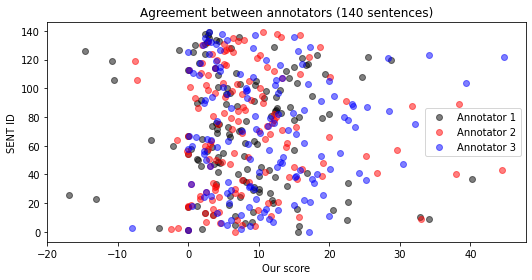

In [5]:
# Calculate the inter-annotator agreement on sentence-level scores
final = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    
    # Delete this: if not all scores are present, skip this sentence
    if len(scores) != 3:
        continue
    
    final.append(scores)

# Plot the scores for each sentence
ann_mapping = {
    0: 'black',
    1: 'red',
    2: 'blue'
}
for ann in range(0, 3):
    pts = [(i, score) for i, score in enumerate([x[ann] for x in final])]
    plt.scatter([p[1] for p in pts], [p[0] for p in pts], c=ann_mapping[ann], alpha=0.5, label=f'Annotator {ann+1}')
plt.xlabel('Our score')
plt.ylabel('SENT ID')
plt.title(f'Agreement between annotators ({len(pts)} sentences)')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

In [6]:
# Calculates Rough Span Agreement Score
# TODO: Does not work for multiple batches
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    agg_score = 0
    for val in list(orig_tokens.values()) + list(simp_tokens.values()):
        agg_score += (list(val.values())[0] - 3)
    total_agreement.append(agg_score)
print(f"Sent with full agreement {sum([x == 0 for x in total_agreement])} / {MAX_HIT}")
# hds = sorted([(i, val) for i, val in enumerate(total_agreement)], key=lambda x: x[1])
# print("\nHighest disagreement sentences:")
# for x in [get_sent_info(data[x[0]]) for x in hds][:5]:
#     print(x)

Sent with full agreement 7 / 149


{(0, 10): {'substitution': 3, 'reorder': 1},
 (11, 19): {'substitution': 3, 'reorder': 1},
 (20, 26): {'reorder': 1},
 (27, 30): {'reorder': 1},
 (31, 34): {'reorder': 1},
 (35, 37): {'reorder': 1},
 (38, 49): {'reorder': 1},
 (50, 52): {'reorder': 1},
 (53, 66): {'reorder': 1},
 (81, 84): {'structure': 2, 'substitution': 1},
 (85, 90): {'structure': 2, 'substitution': 2},
 (91, 93): {'structure': 2, 'substitution': 1},
 (113, 116): {'structure': 2, 'deletion': 1},
 (117, 119): {'structure': 2, 'deletion': 1},
 (120, 123): {'structure': 1, 'reorder': 2},
 (124, 131): {'structure': 1, 'reorder': 2},
 (132, 141): {'structure': 1, 'reorder': 2},
 (142, 145): {'structure': 1, 'reorder': 2},
 (146, 150): {'structure': 1, 'reorder': 2},
 (151, 153): {'structure': 1, 'reorder': 2},
 (154, 158): {'structure': 1, 'reorder': 2},
 (159, 161): {'structure': 1, 'reorder': 2},
 (162, 167): {'structure': 1, 'reorder': 2},
 (168, 172): {'substitution': 1, 'deletion': 1},
 (173, 176): {'deletion': 1, '

{(0, 2): {'insertion': 2, 'substitution': 1},
 (3, 6): {'insertion': 3},
 (7, 12): {'substitution': 3, 'reorder': 1},
 (13, 21): {'substitution': 3, 'reorder': 1},
 (22, 28): {'reorder': 1},
 (29, 32): {'reorder': 1},
 (33, 36): {'reorder': 1},
 (37, 39): {'reorder': 1},
 (40, 51): {'reorder': 1},
 (52, 54): {'reorder': 1},
 (55, 68): {'reorder': 1},
 (72, 74): {'structure': 1, 'reorder': 2},
 (75, 80): {'structure': 1, 'reorder': 2},
 (81, 84): {'structure': 1, 'reorder': 2},
 (85, 92): {'structure': 1, 'reorder': 2},
 (93, 102): {'structure': 1, 'reorder': 2},
 (103, 106): {'structure': 1, 'reorder': 2},
 (107, 111): {'structure': 1, 'reorder': 2},
 (112, 114): {'structure': 1, 'reorder': 2},
 (115, 119): {'structure': 1, 'reorder': 2},
 (120, 128): {'structure': 2, 'substitution': 2},
 (148, 151): {'substitution': 1, 'insertion': 2},
 (152, 155): {'insertion': 1, 'substitution': 1},
 (156, 165): {'insertion': 1, 'substitution': 1, 'structure': 2},
 (166, 168): {'insertion': 2, 'stru

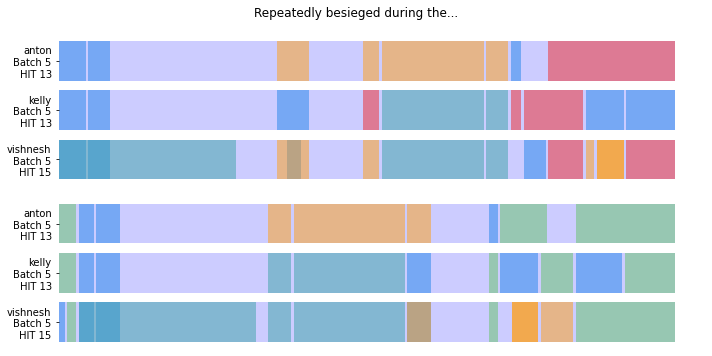

In [7]:
HID_ID = 12
sents = [x for x in data if x['id'] == HID_ID]
orig_tokens = get_annotations_per_token(sents, 'original')
simp_tokens = get_annotations_per_token(sents, 'simplified')

display(orig_tokens)
display(simp_tokens)
draw_agreement(sents)

In [8]:
# Calculates % Agreement
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    total_agreement += list(orig_tokens.values()) + list(simp_tokens.values())

for edit_type in edit_type_labels:
    out = {
        3: 0,
        2: 0,
        1: 0
    }
    for d in total_agreement:
        if edit_type in d.keys():
            if d[edit_type] not in out.keys():
                out[d[edit_type]] = 0
            out[d[edit_type]] += 1
    total = sum(out.values())
    # Avoid division by 0, doesn't change calculation at all
    total = 1 if total == 0 else total
    print(f'{edit_type}: {int(100*out[3]/total)} {int(100*out[2]/total)} {int(100*out[1]/total)}')

insertion: 14 28 56
deletion: 45 20 34
substitution: 31 29 39
split: 35 22 41
reorder: 15 22 62
structure: 5 25 68


<AxesSubplot:>

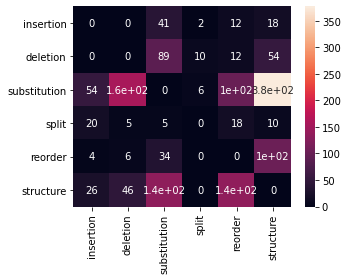

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
ann1, ann2 = [], []

for d in total_agreement:
    # Big asterisk, but we ignore 3 way disagreements
    ks = list(d.keys())
    if len(ks) == 2:
        ann1.append(ks[0])
        ann2.append(ks[1])

a = confusion_matrix(ann1, ann2, labels=edit_type_labels)
df_cm = pd.DataFrame(a, index = [i for i in edit_type_labels],
                  columns = [i for i in edit_type_labels])
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True)

In [8]:
# Some examples of high disagreement
# This isn't the correct way to calculate disagreement between the scores
# high_disagreement = [y[1] for y in sorted([(abs(x[0] - x[1]), i) for i, x in enumerate(scores) if x[0] != 0], reverse=True)][:5]
# for idx in high_disagreement:
#     example = data[idx]
#     print(f'HIT {example["id"] + 1}\nAnnotator: {example["user"]}\nSimpEval Score: {example["simpeval_scores"]}\nOur Score: {example["score"]}\nSystem: {system_name_mapping[example["system"]]}\n')

In [9]:
# Krippendorff's alpha = calculated by a token being labeled between
# annotators

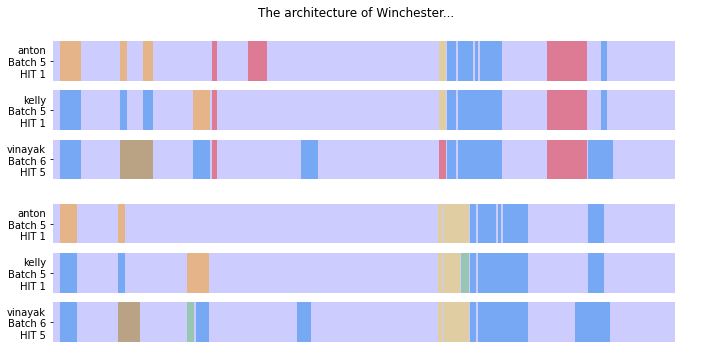

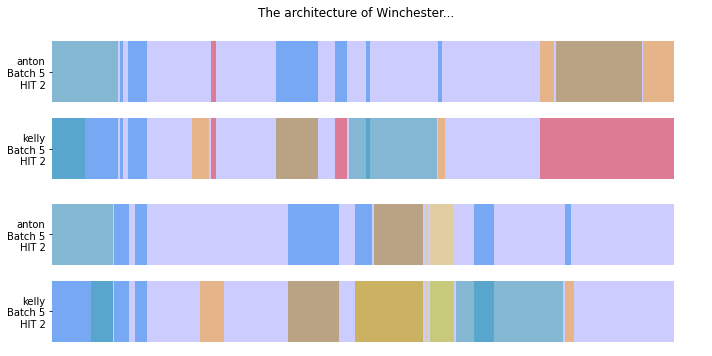

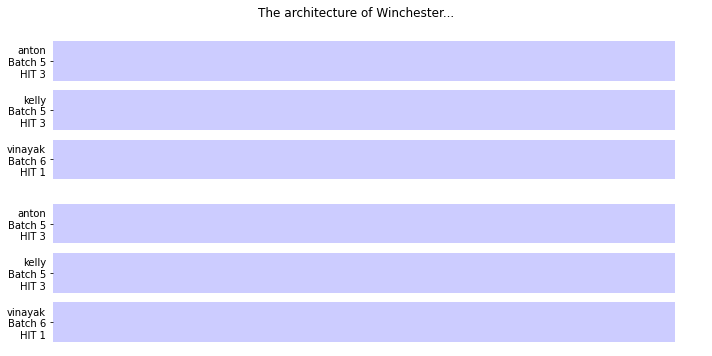

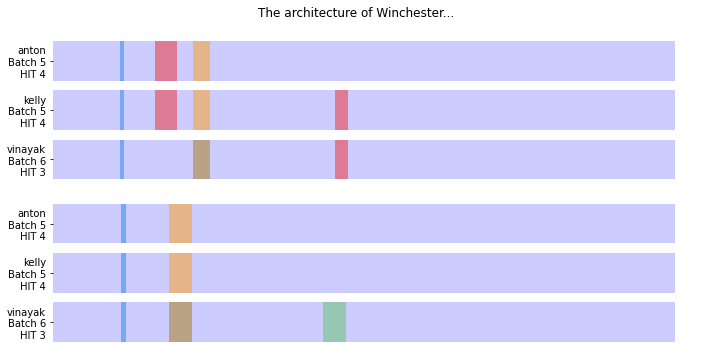

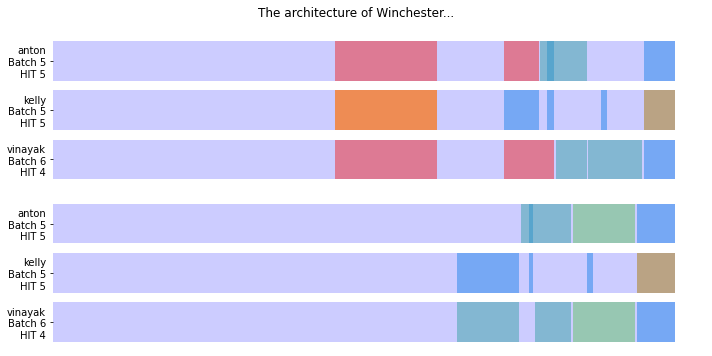

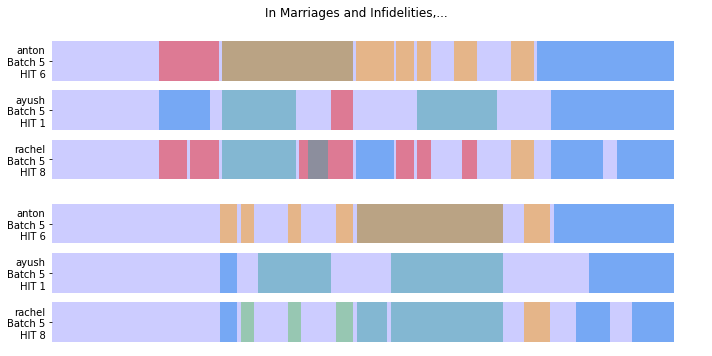

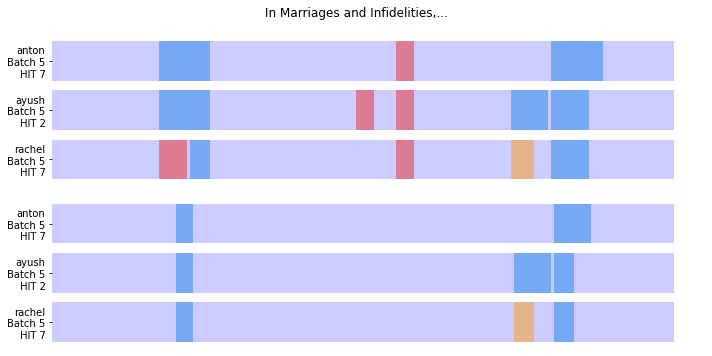

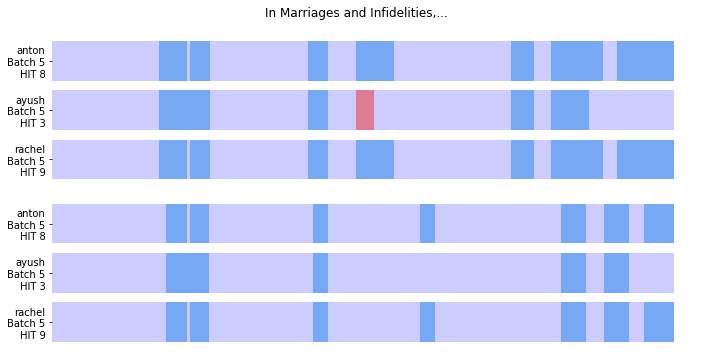

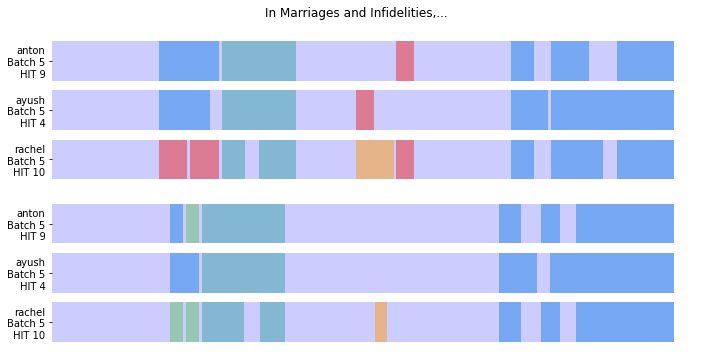

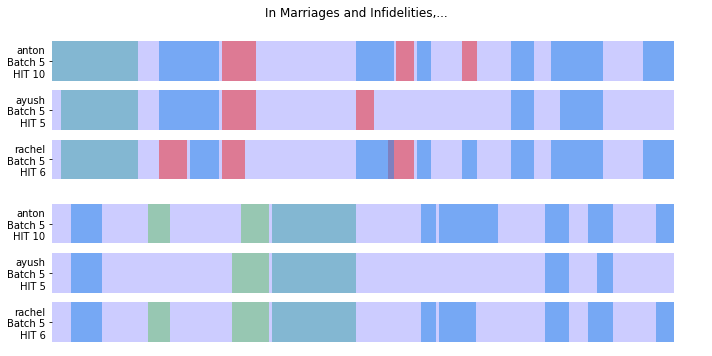

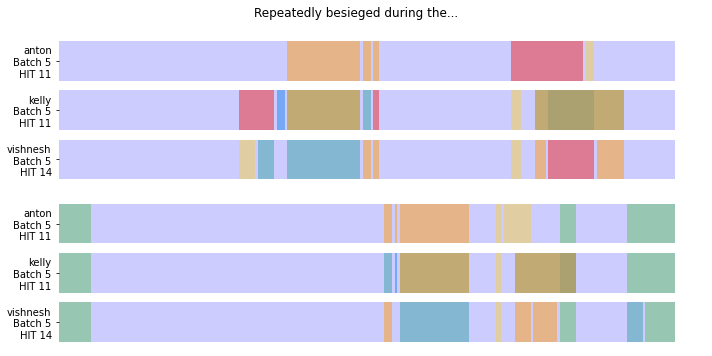

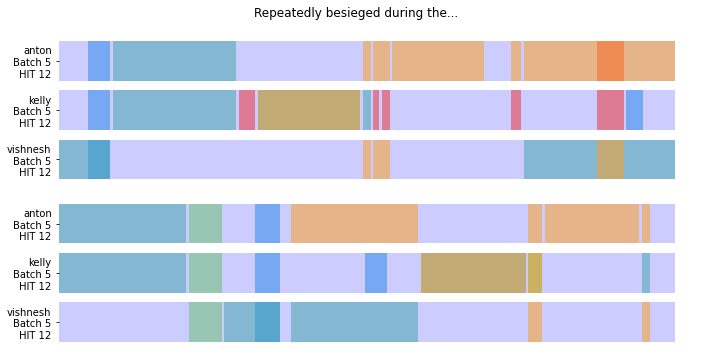

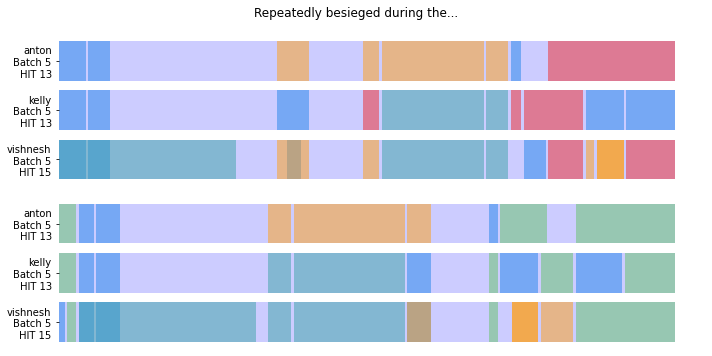

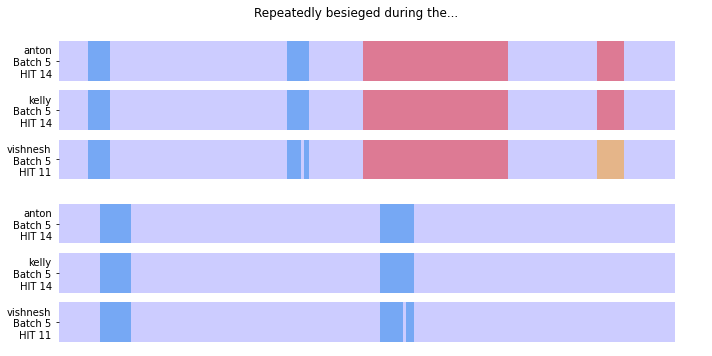

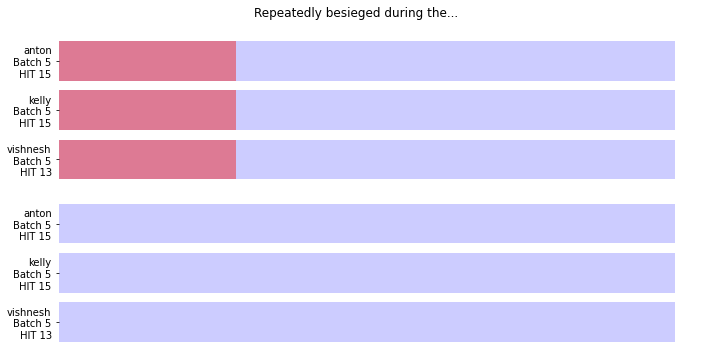

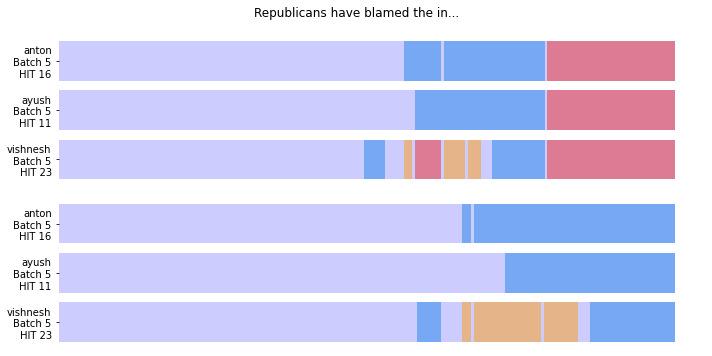

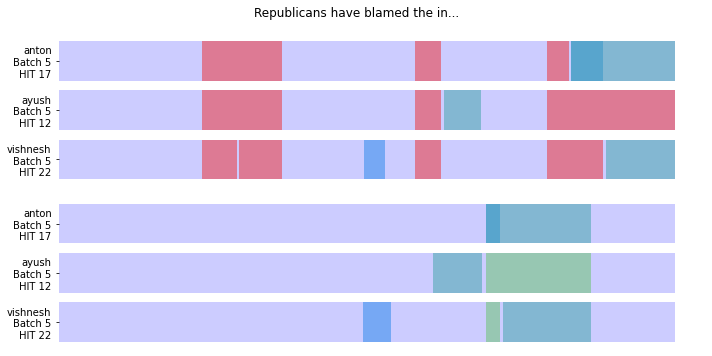

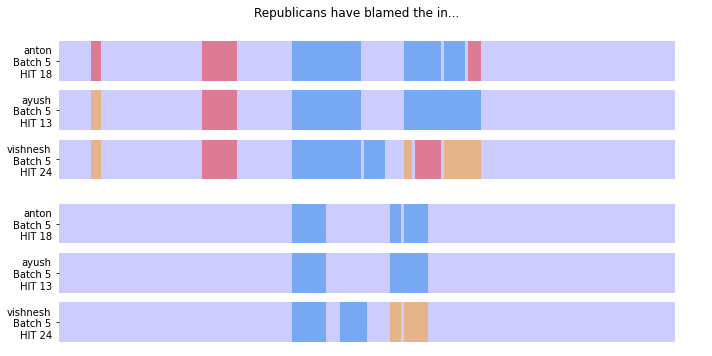

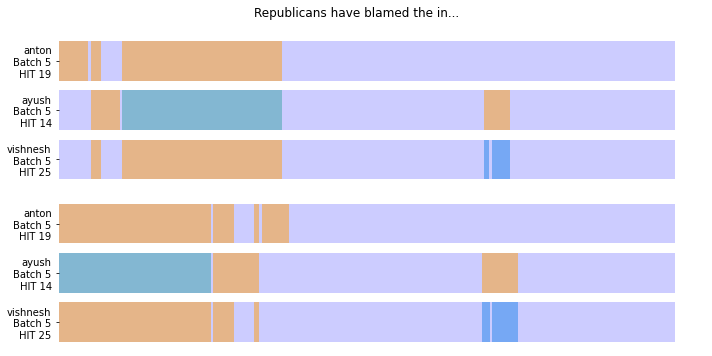

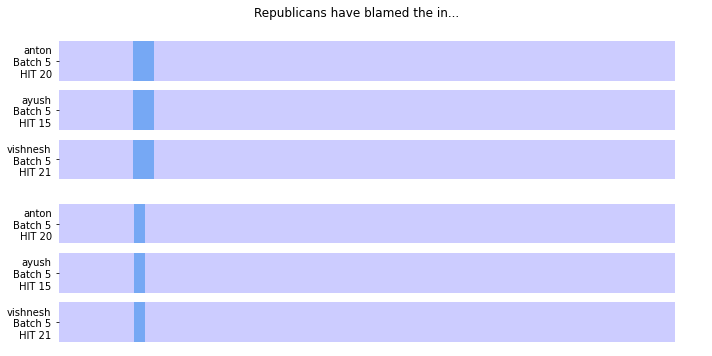

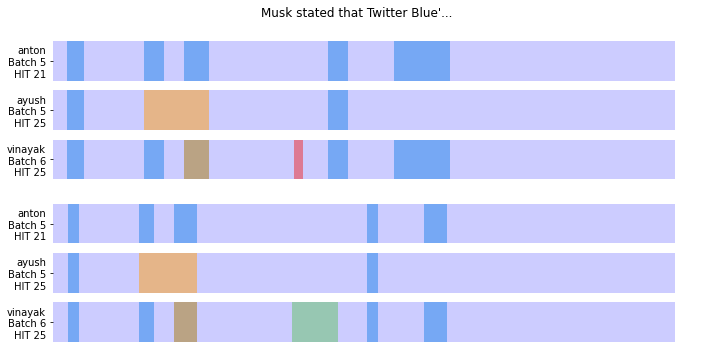

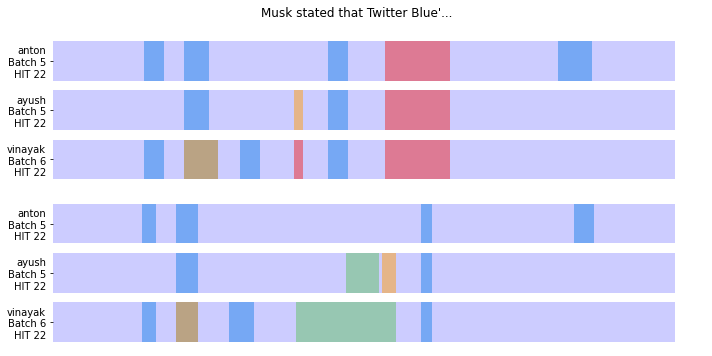

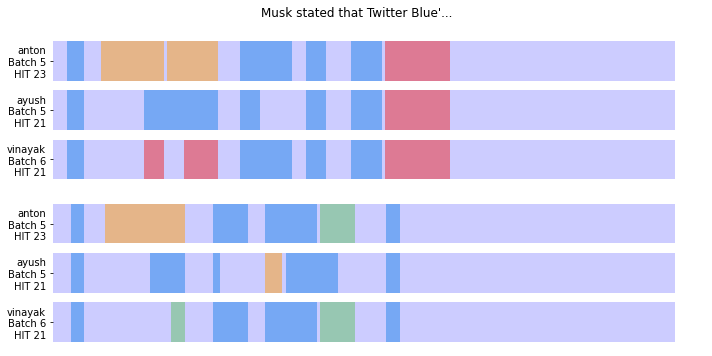

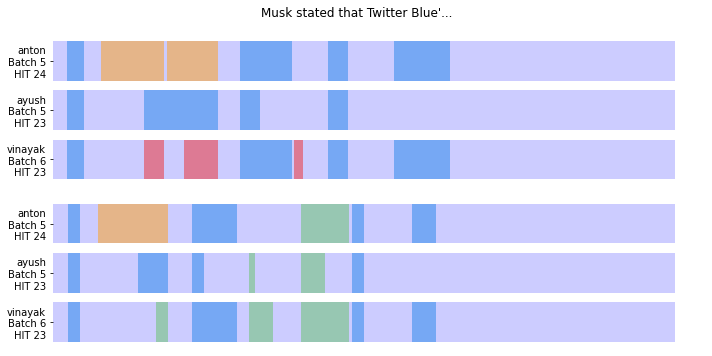

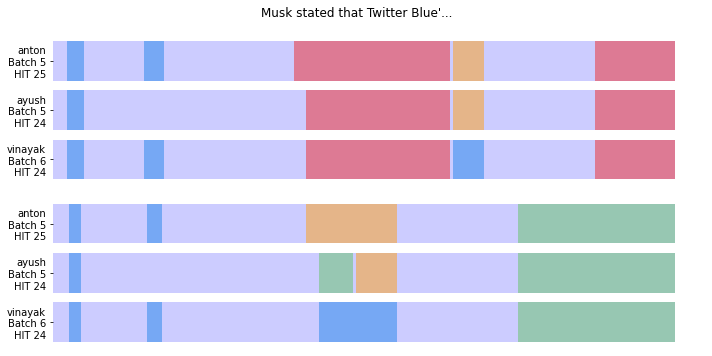

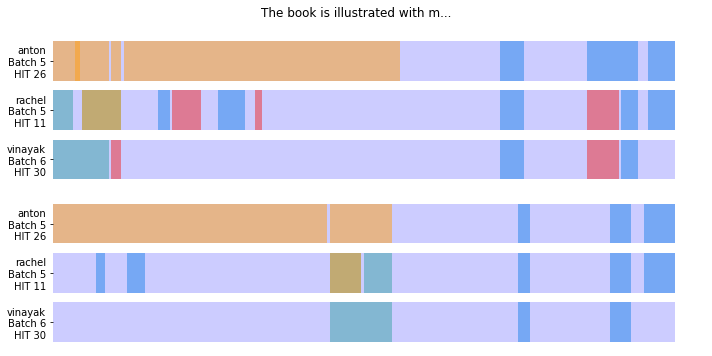

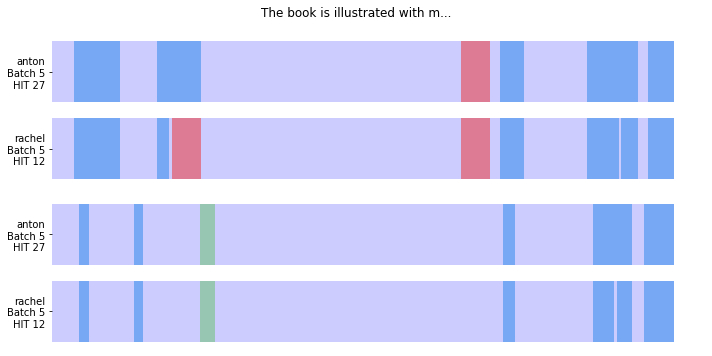

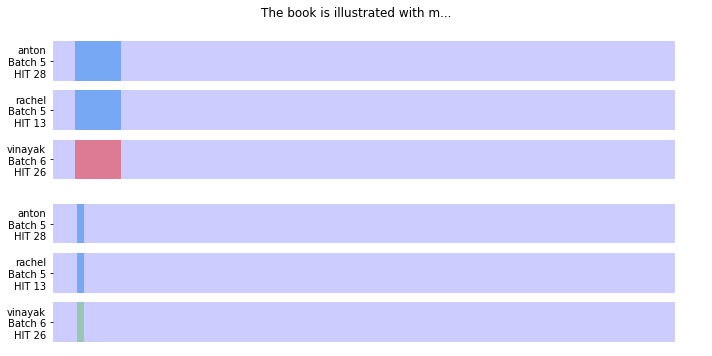

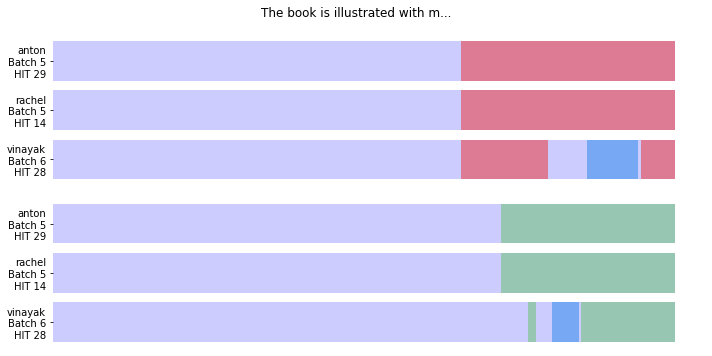

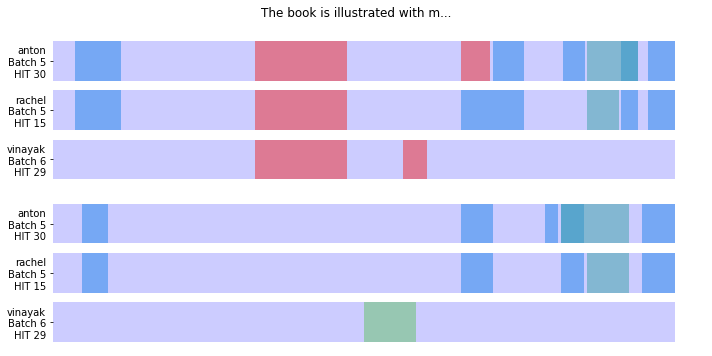

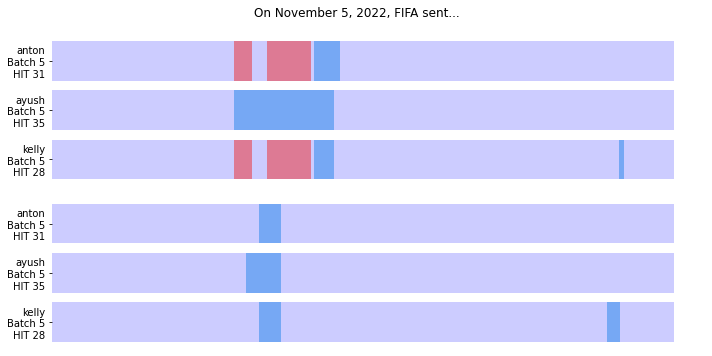

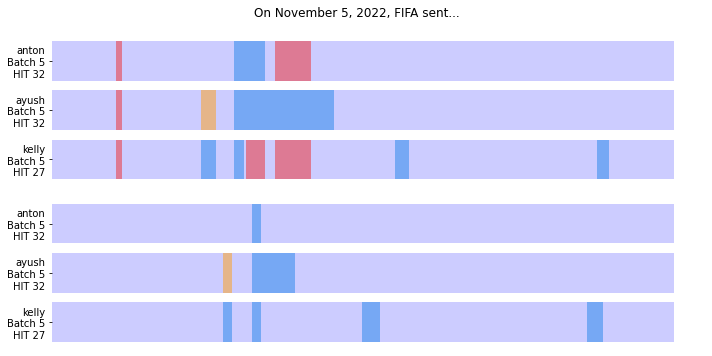

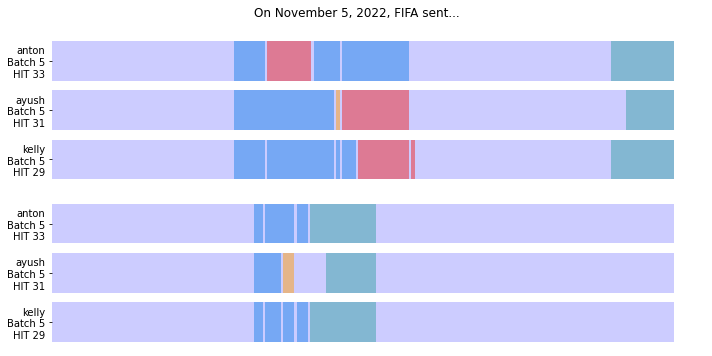

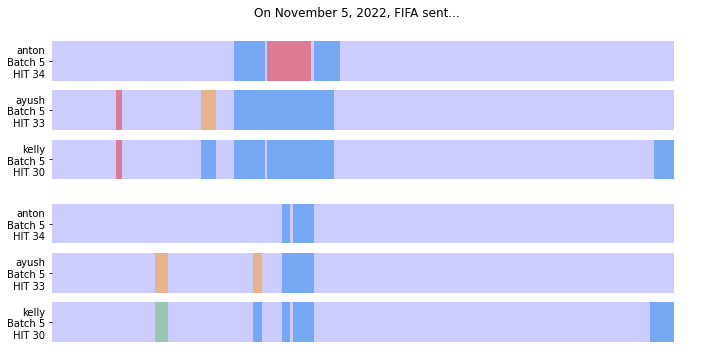

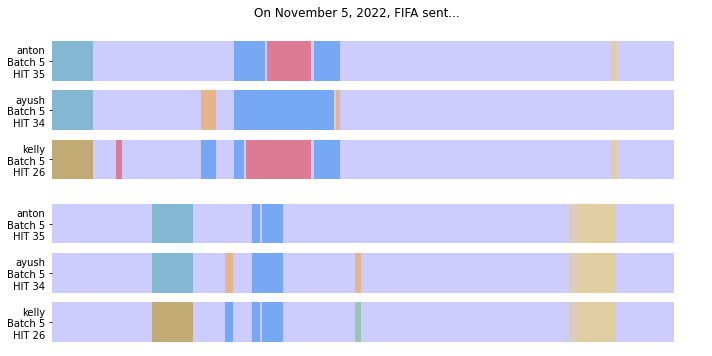

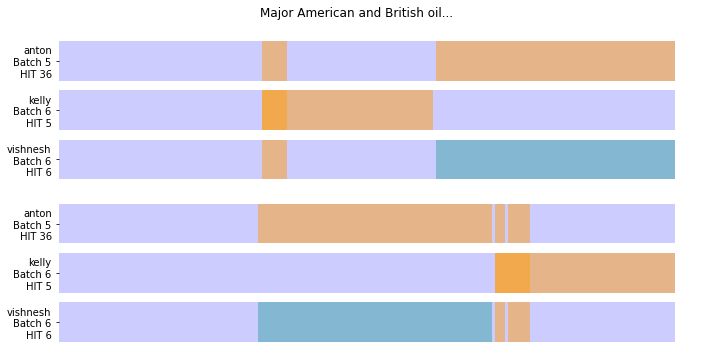

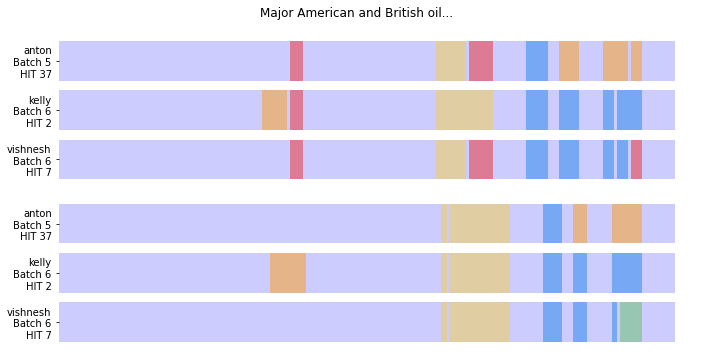

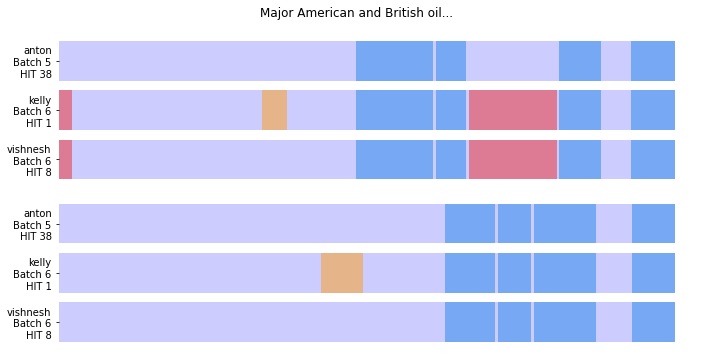

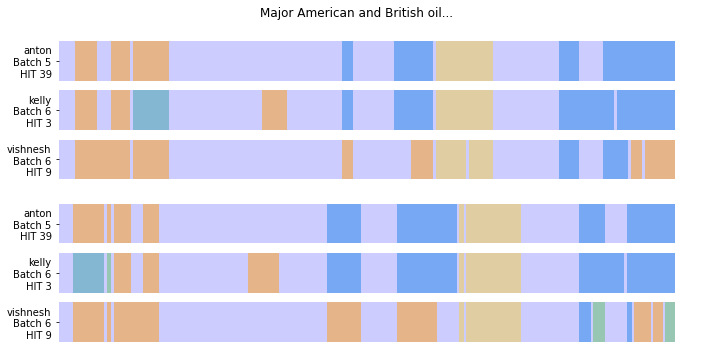

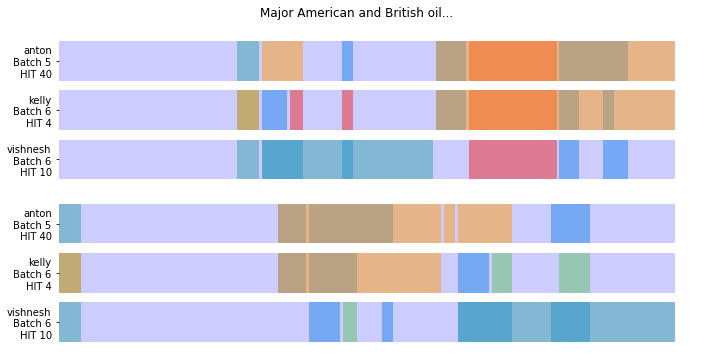

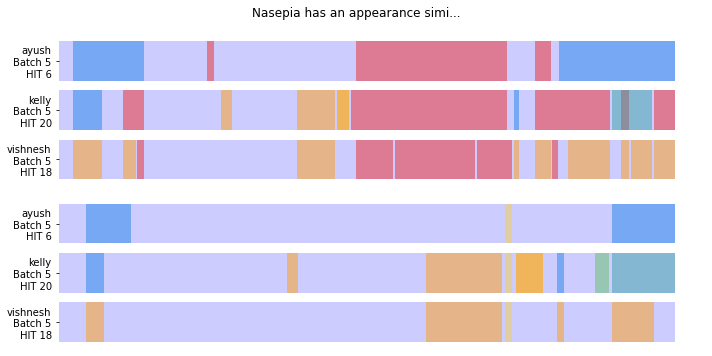

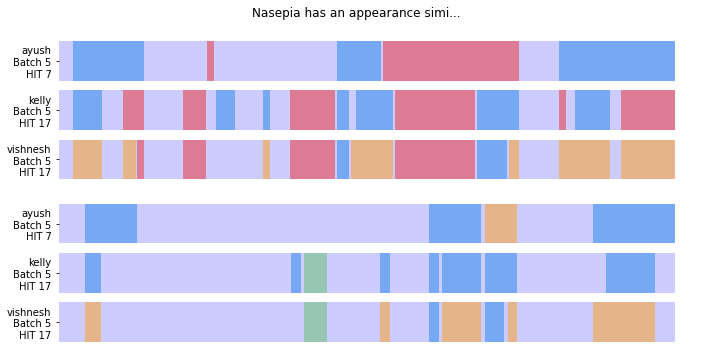

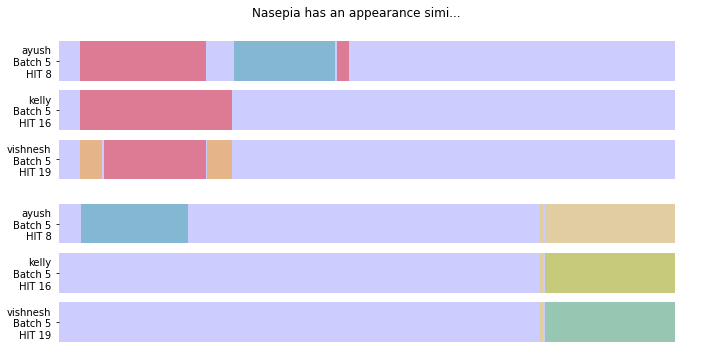

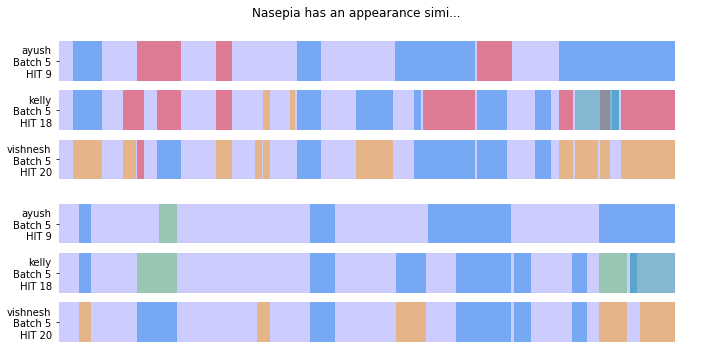

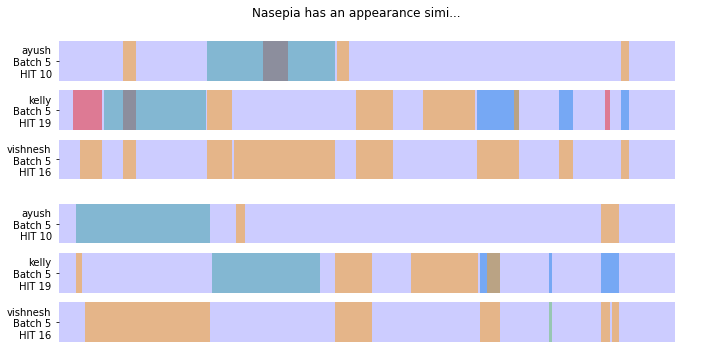

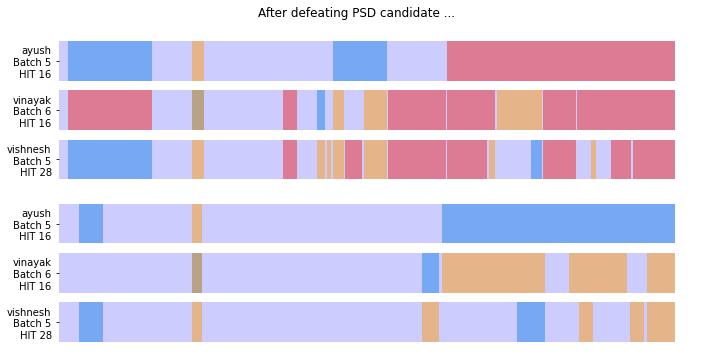

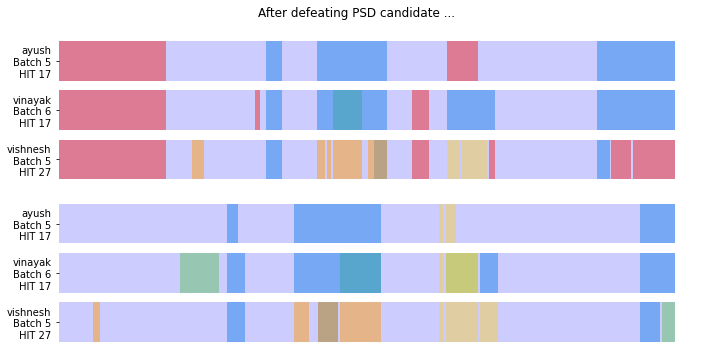

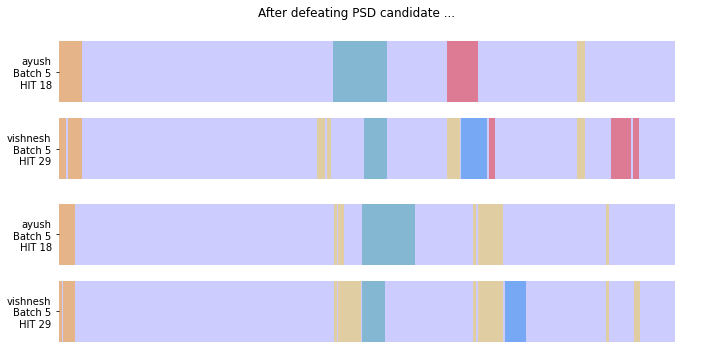

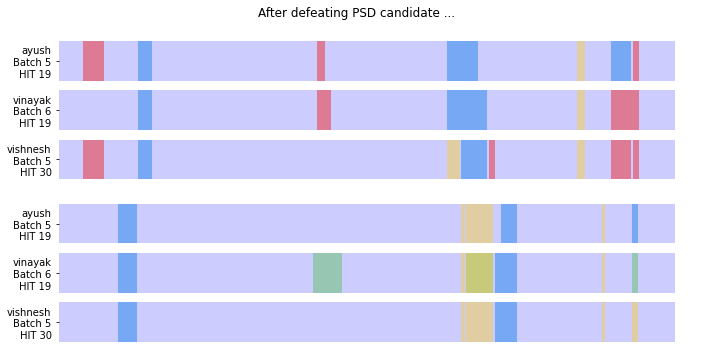

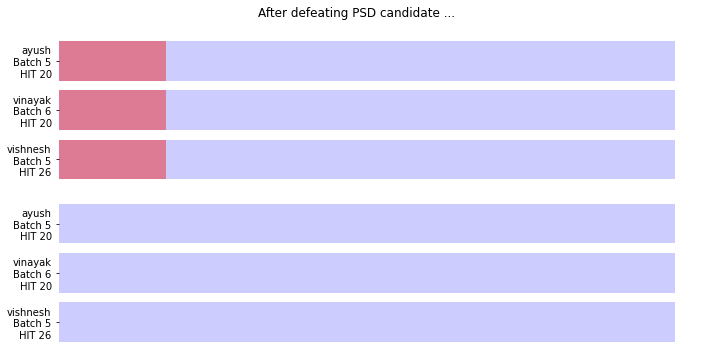

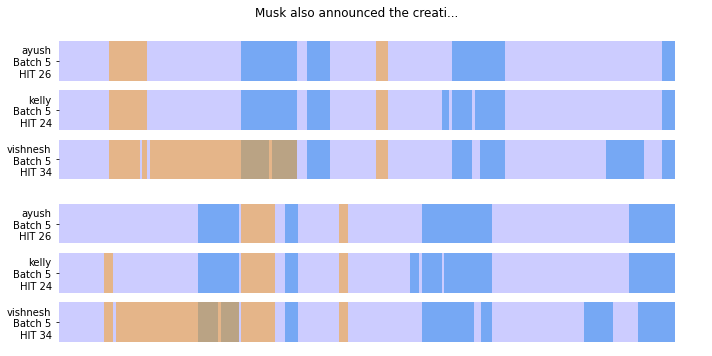

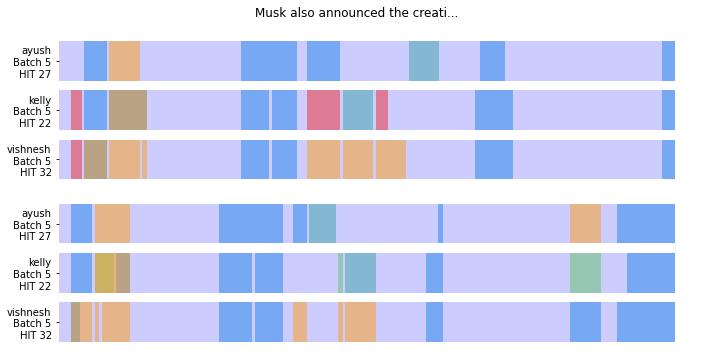

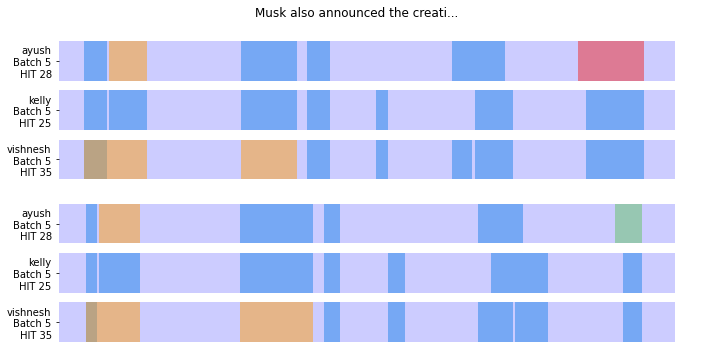

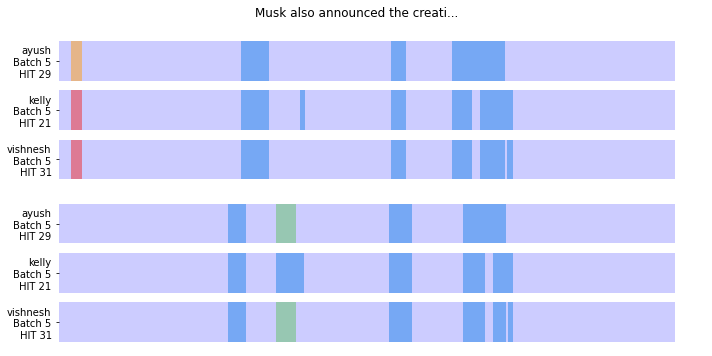

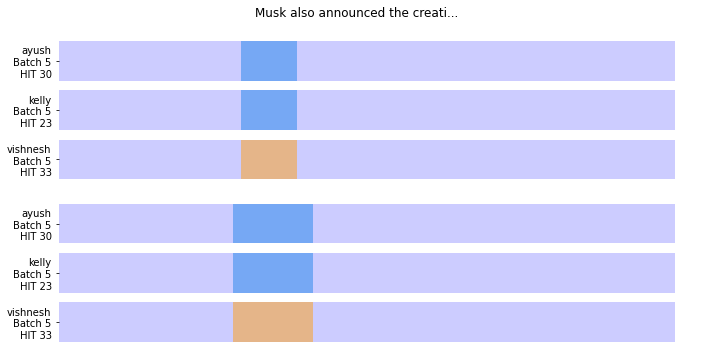

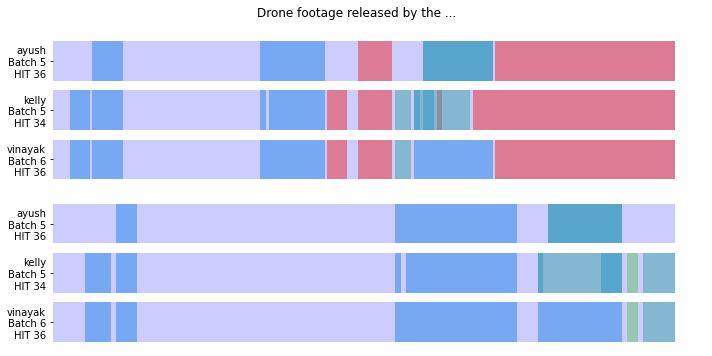

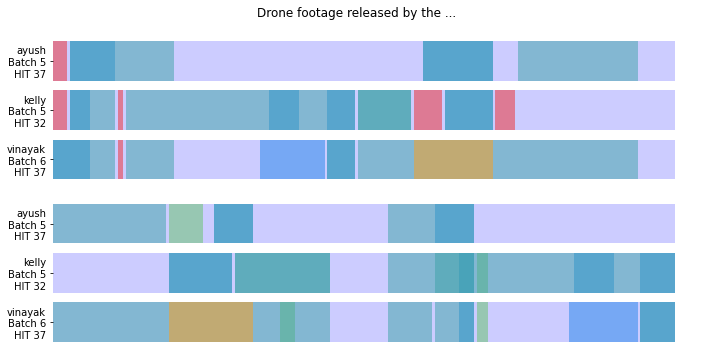

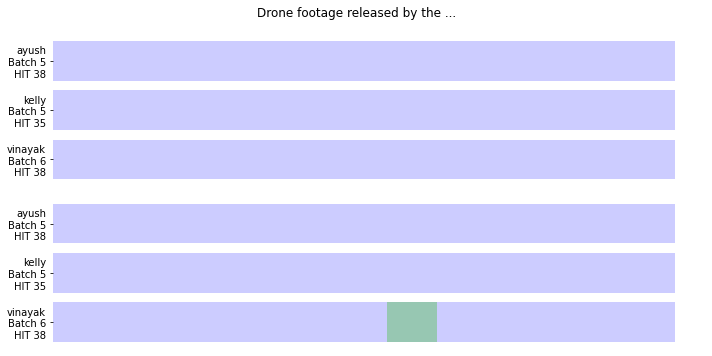

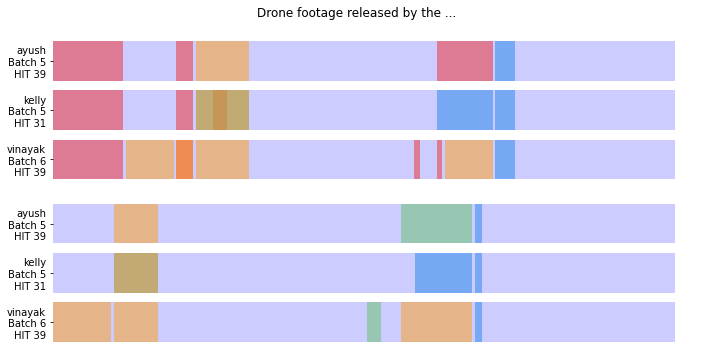

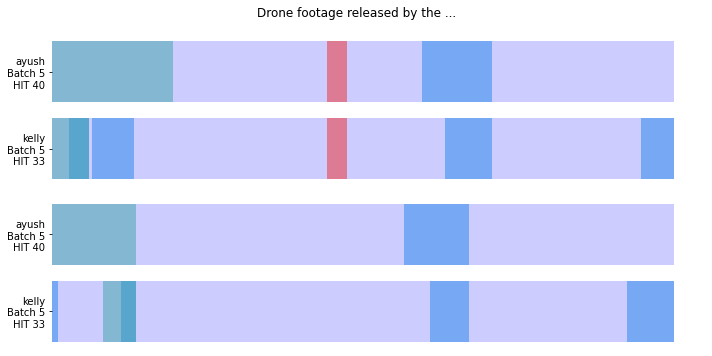

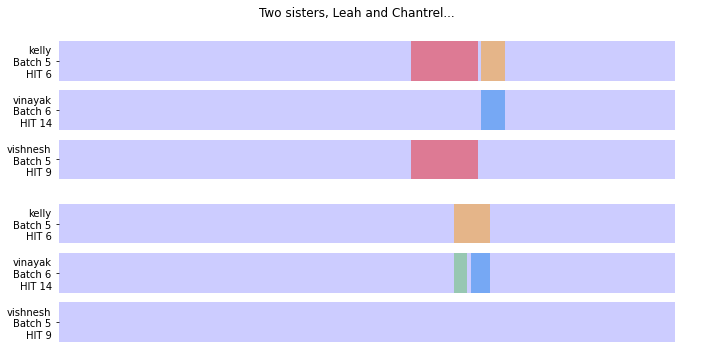

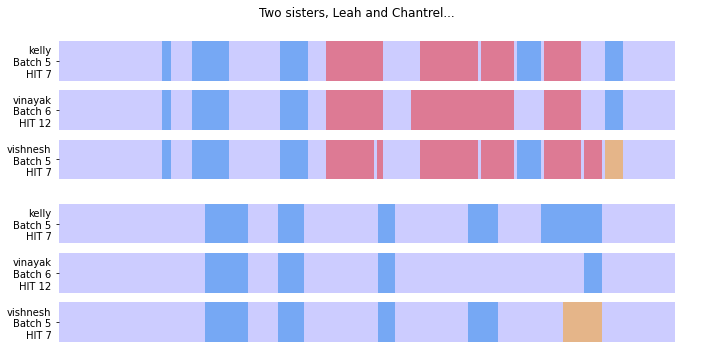

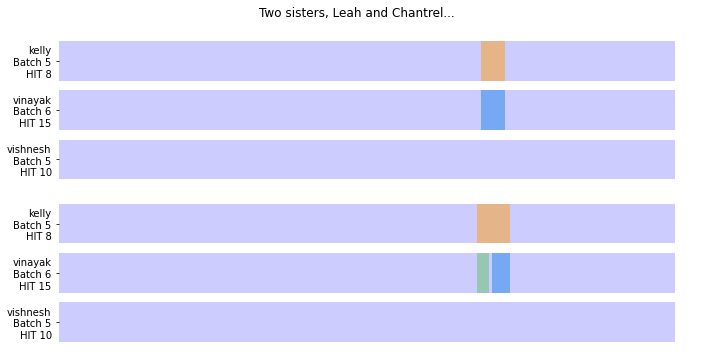

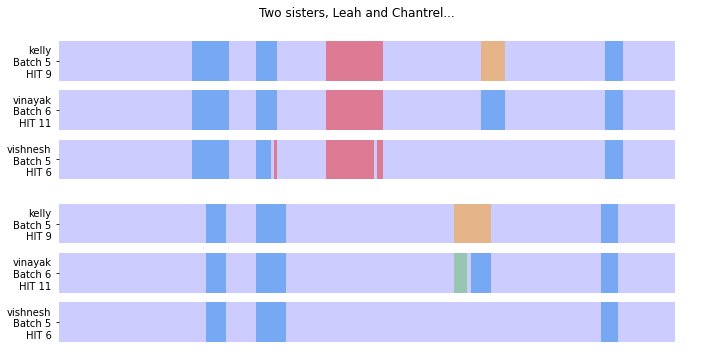

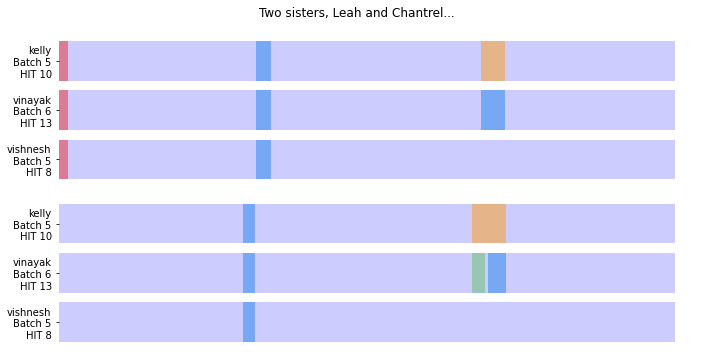

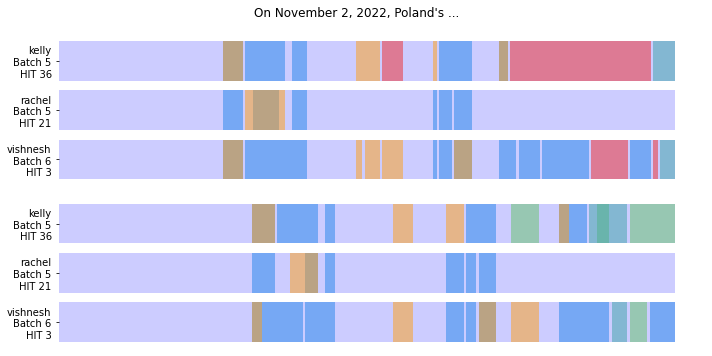

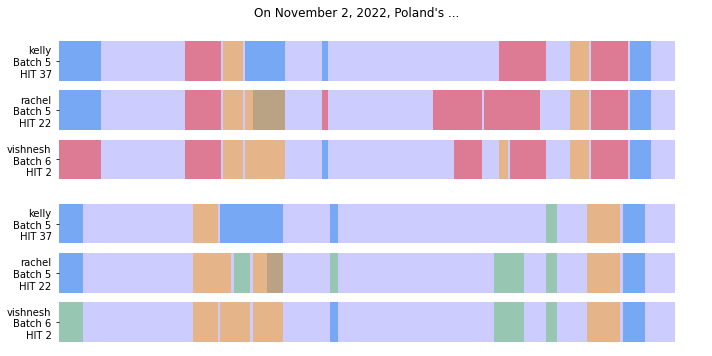

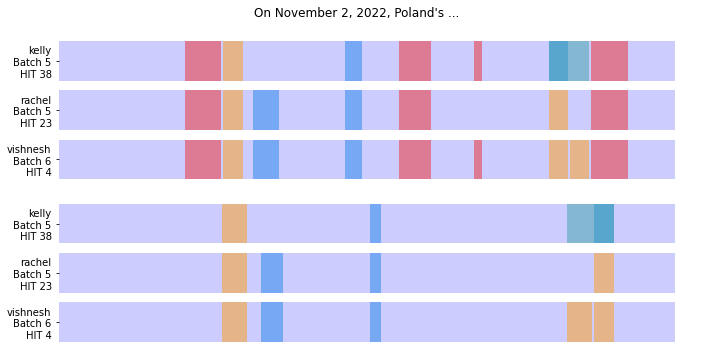

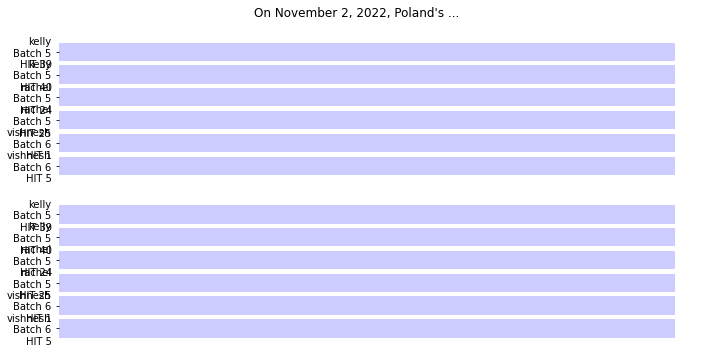

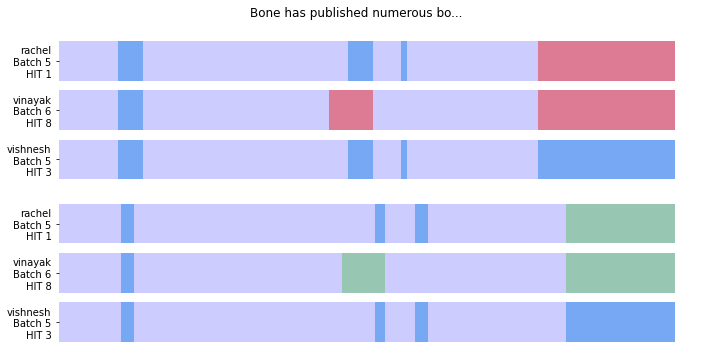

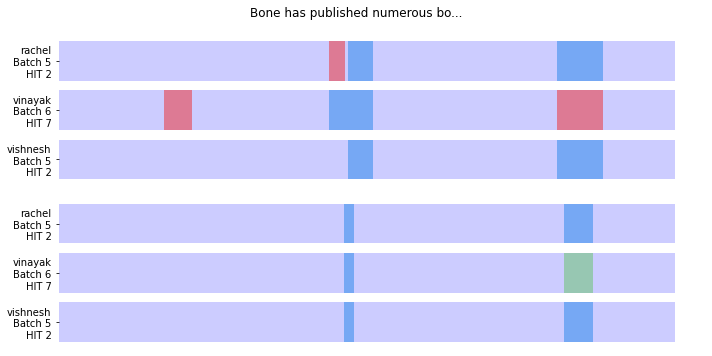

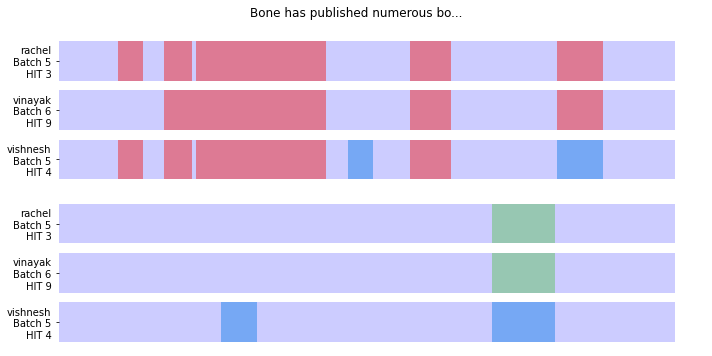

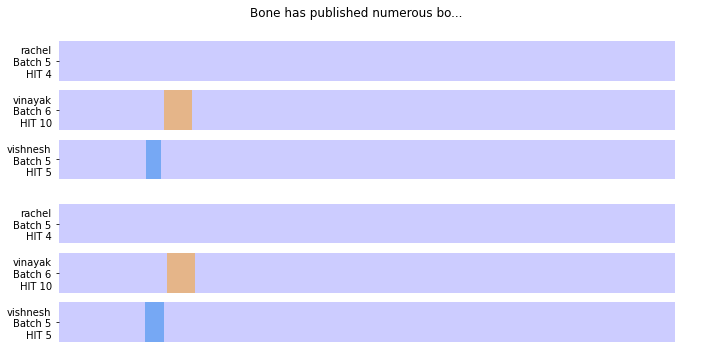

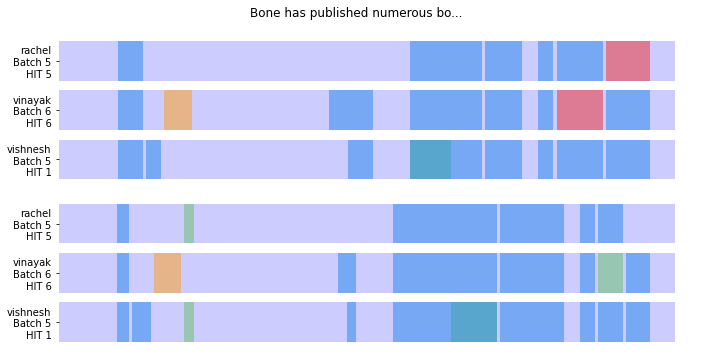

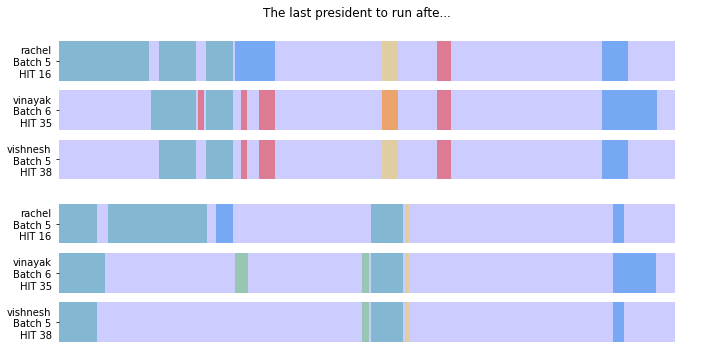

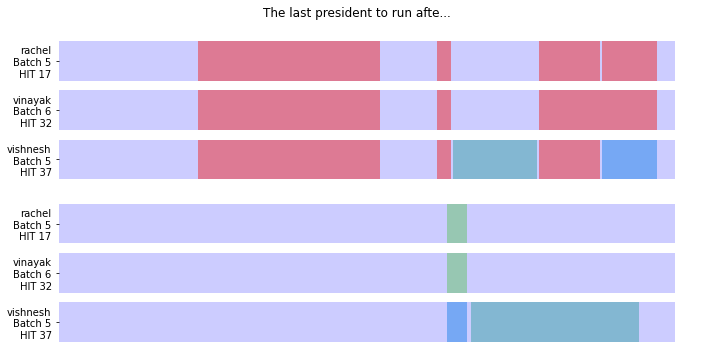

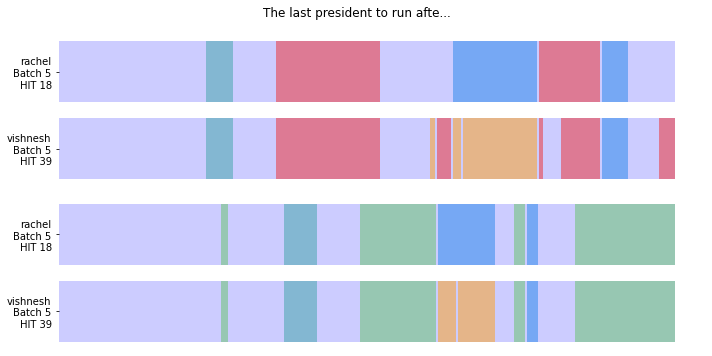

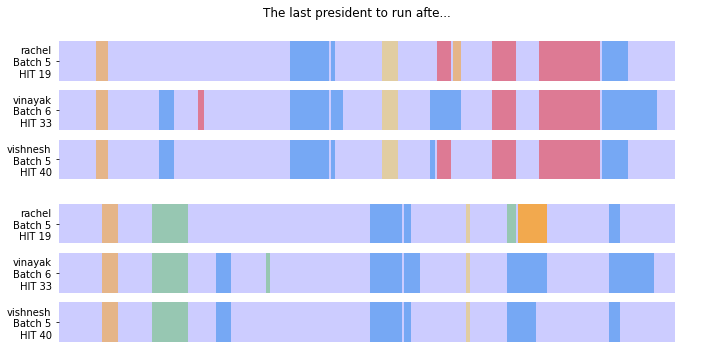

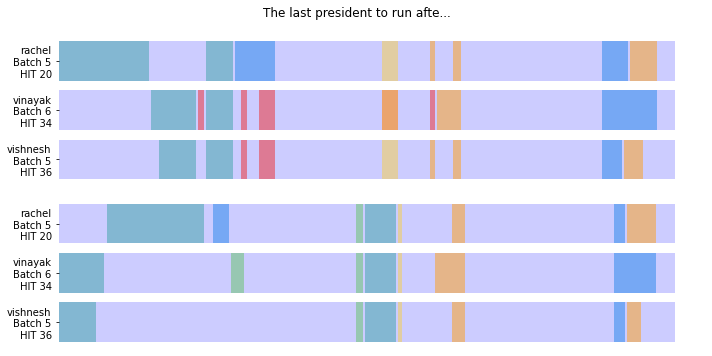

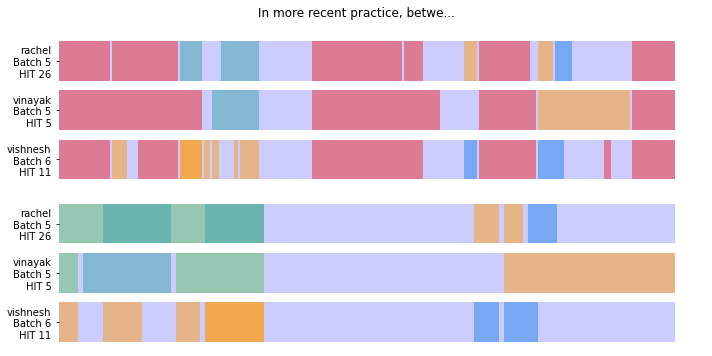

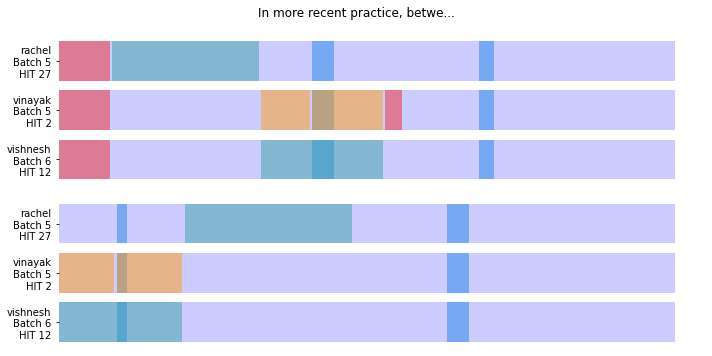

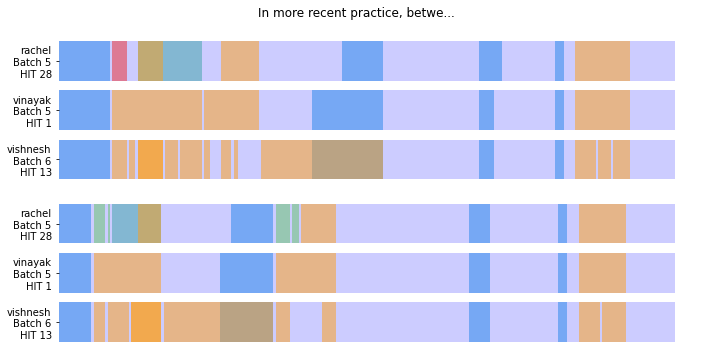

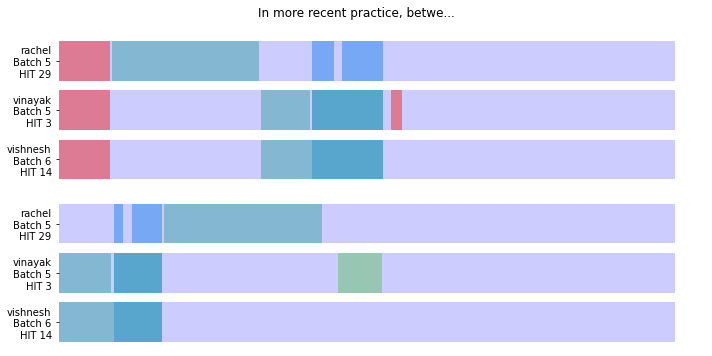

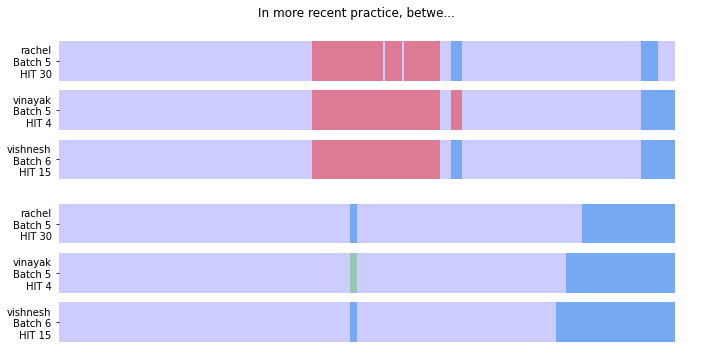

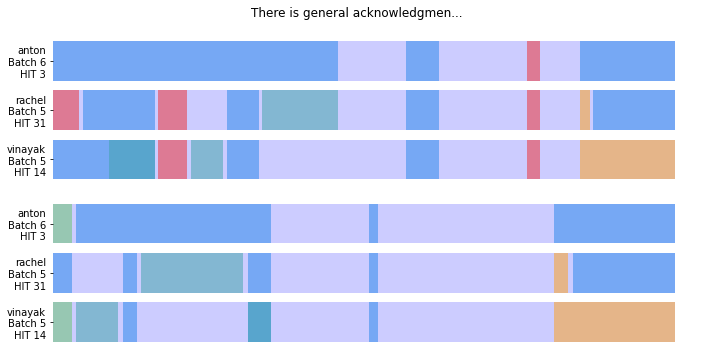

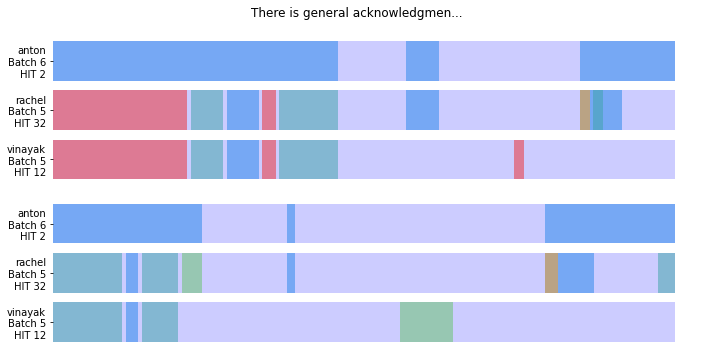

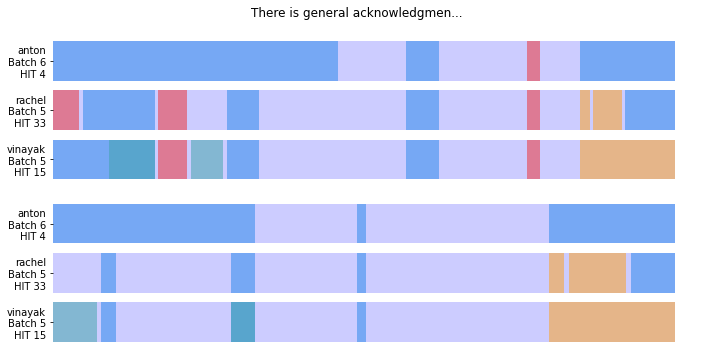

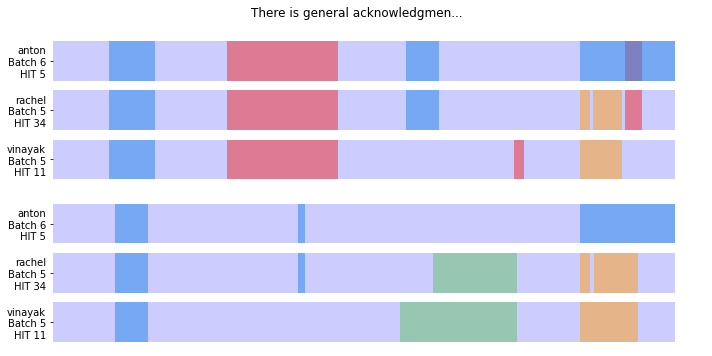

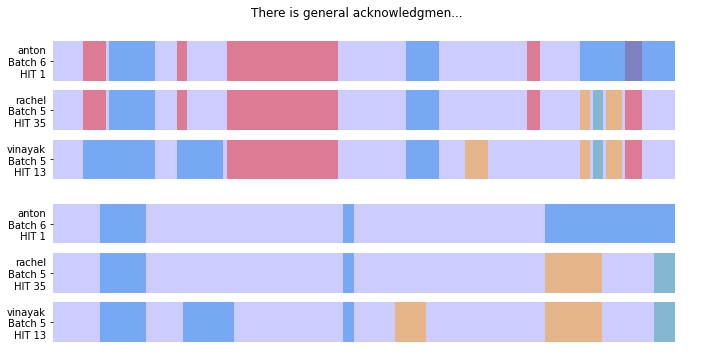

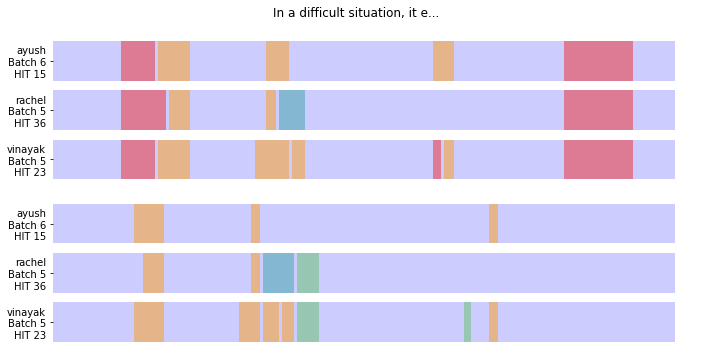

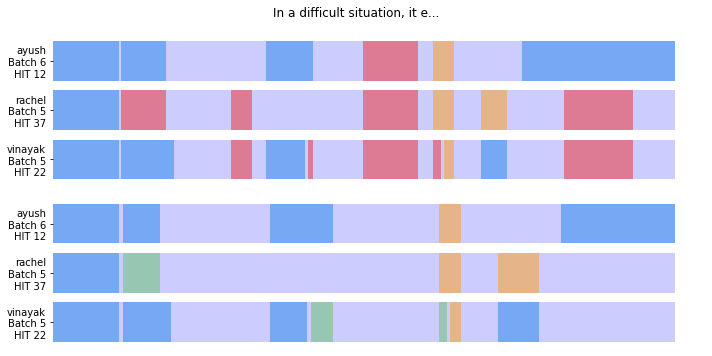

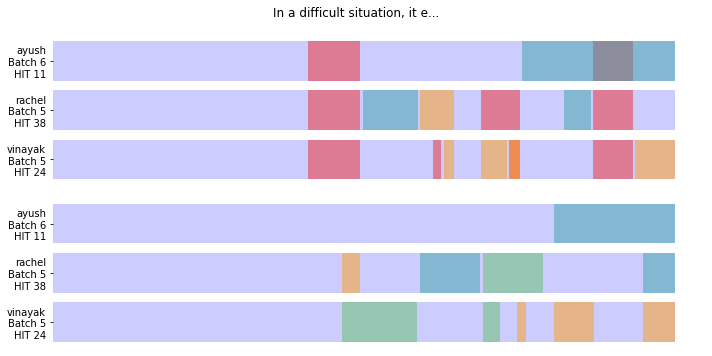

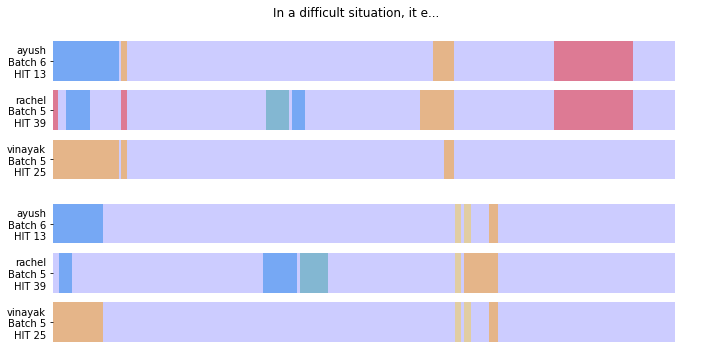

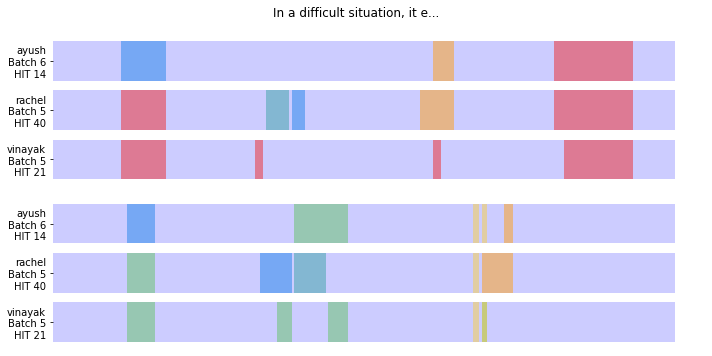

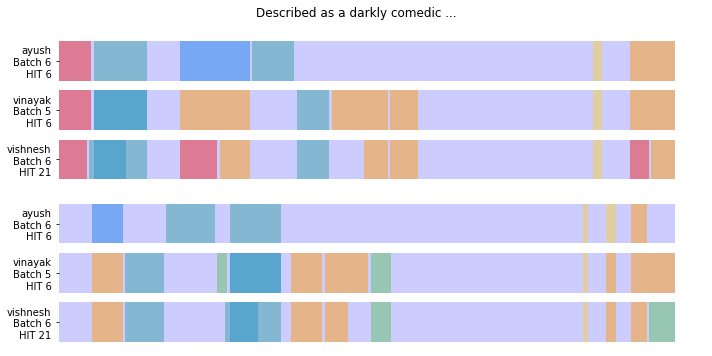

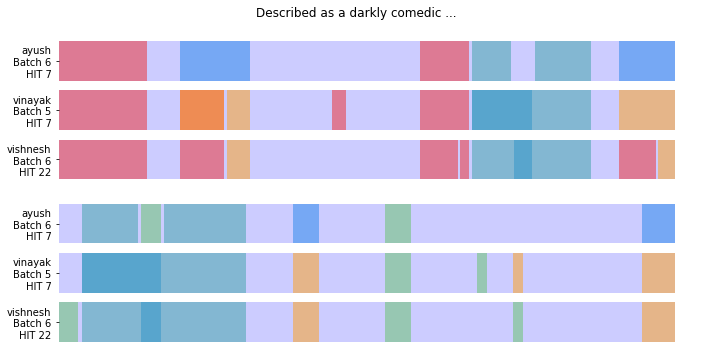

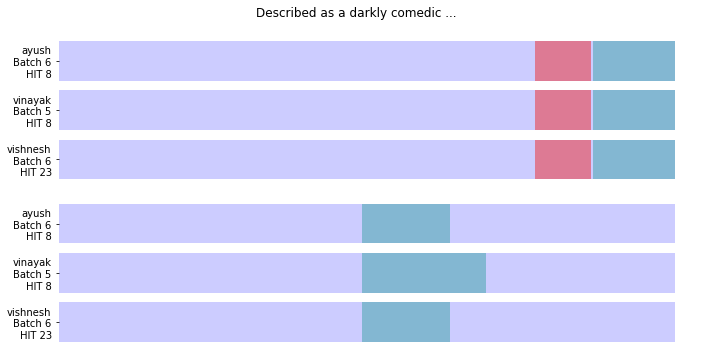

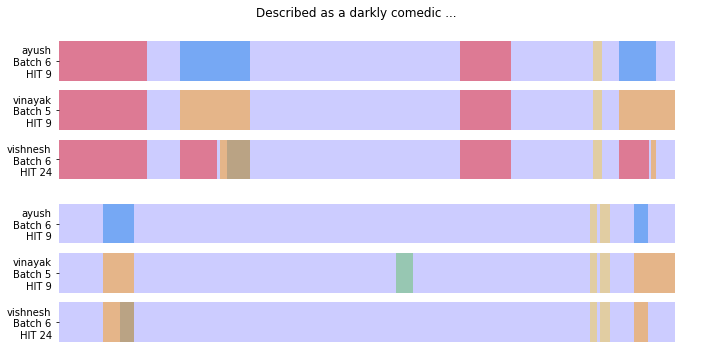

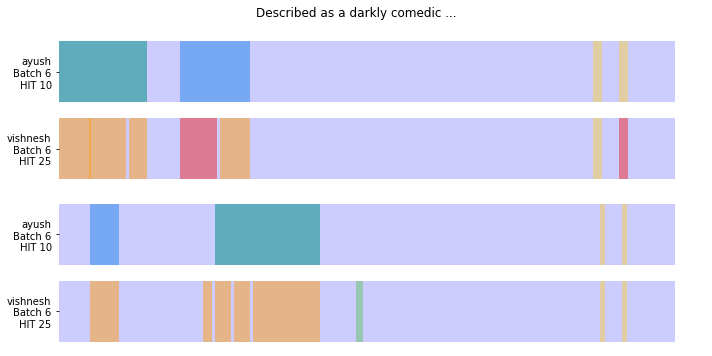

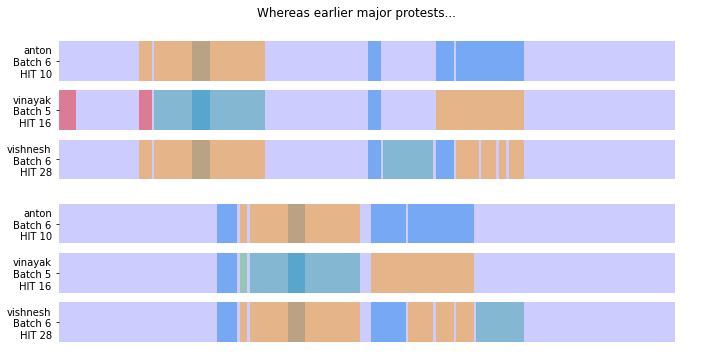

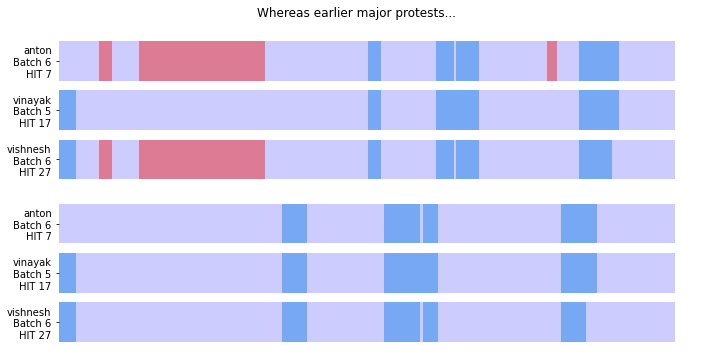

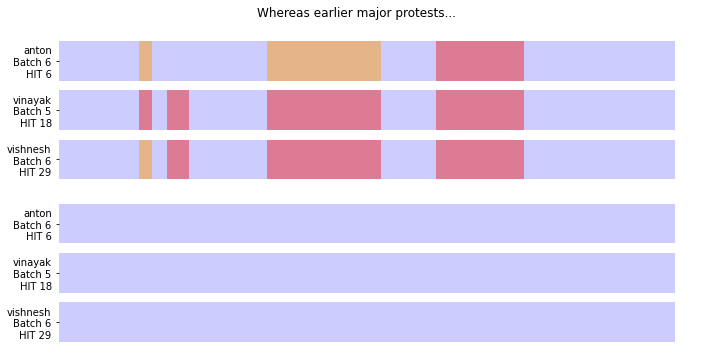

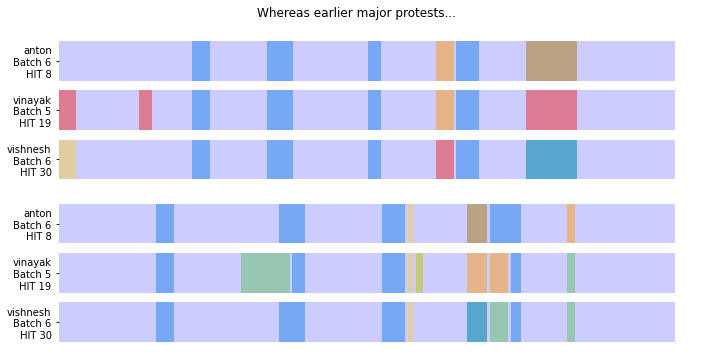

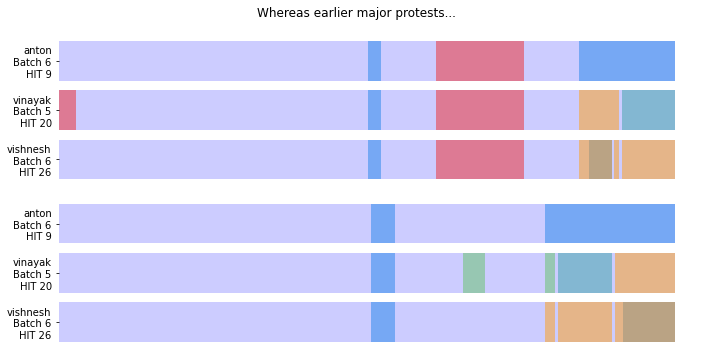

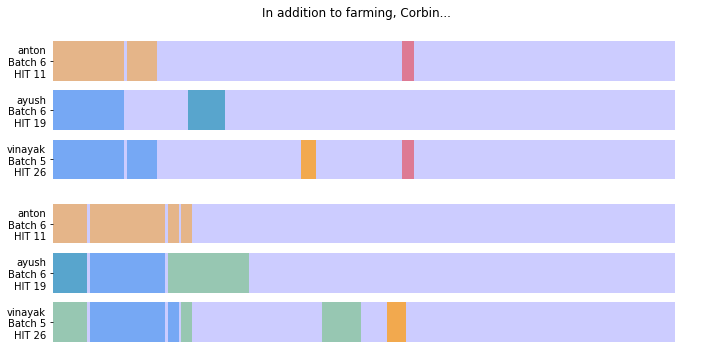

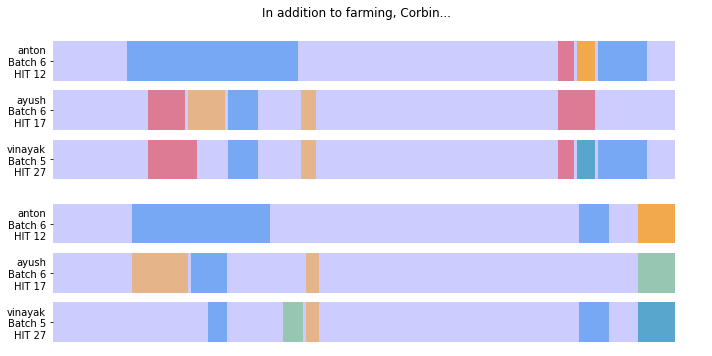

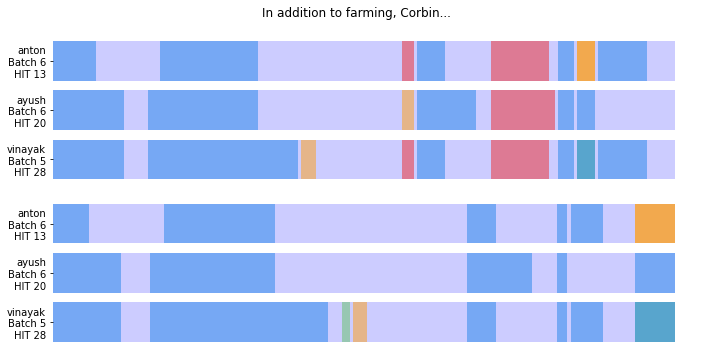

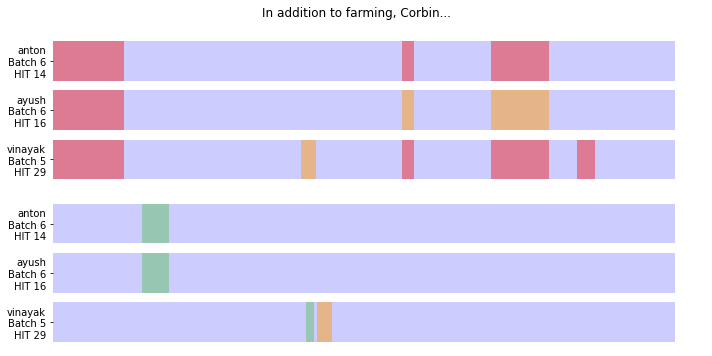

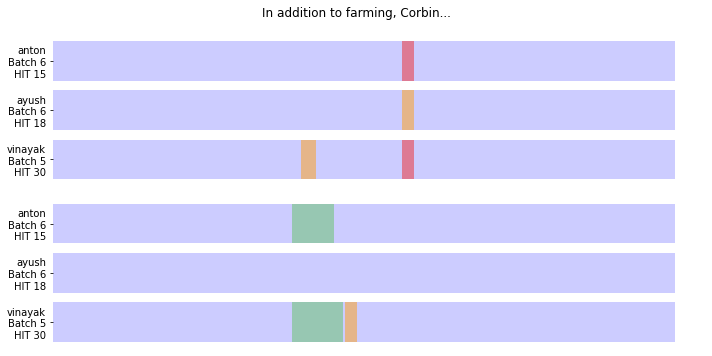

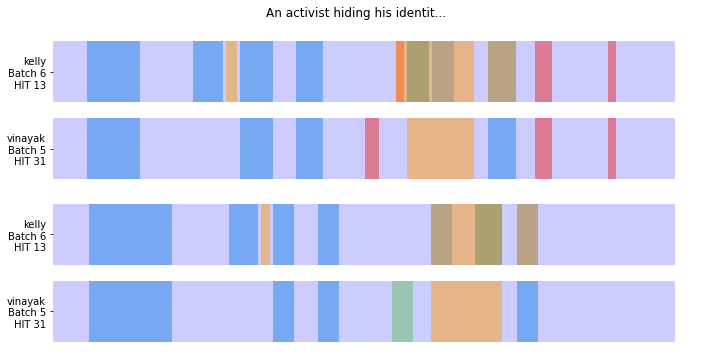

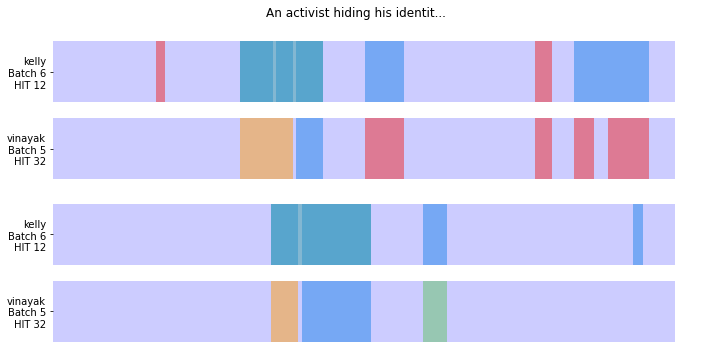

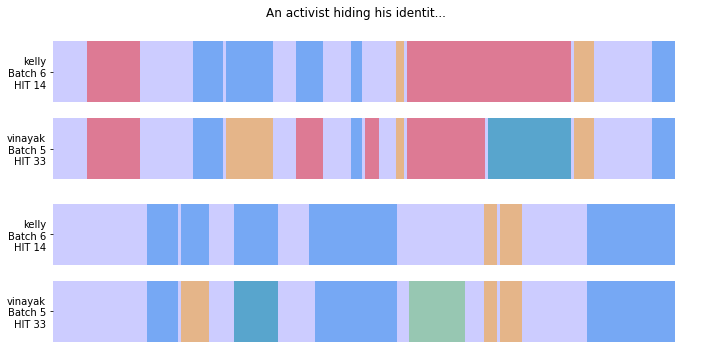

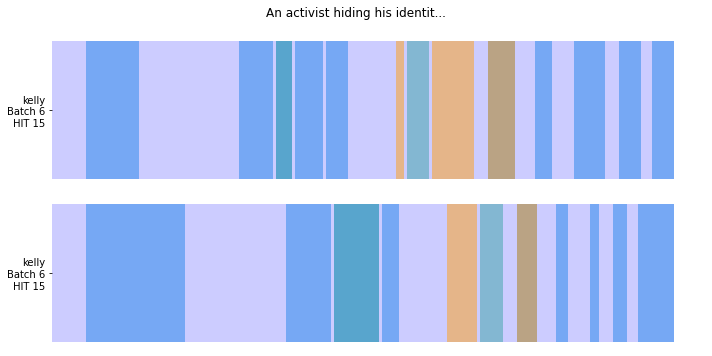

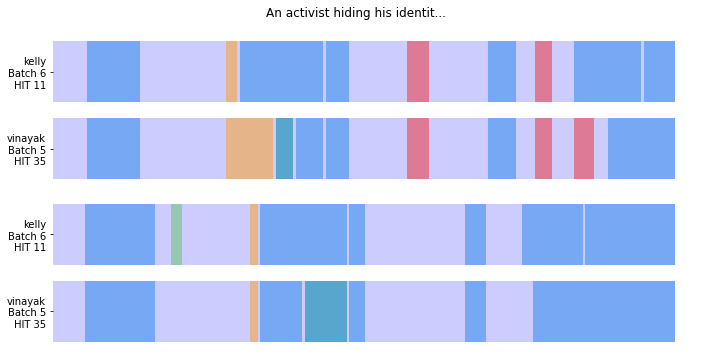

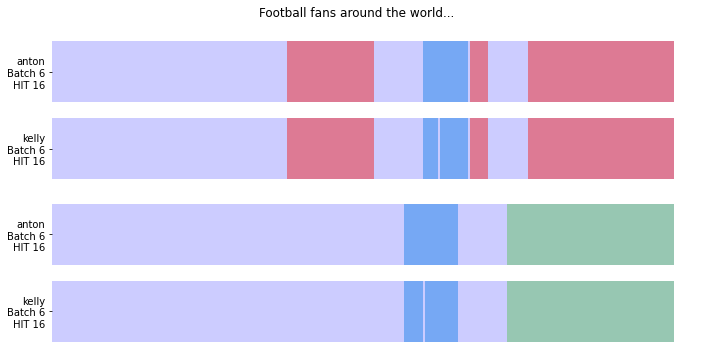

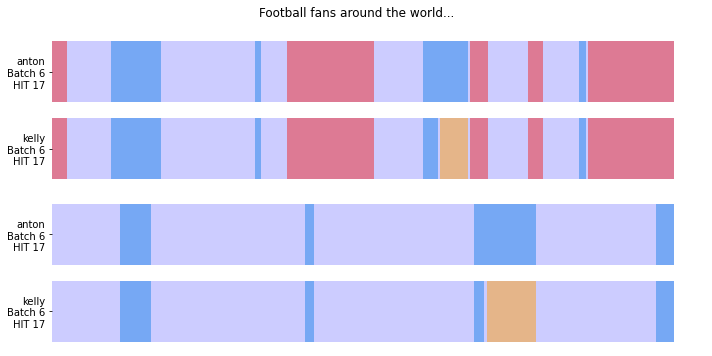

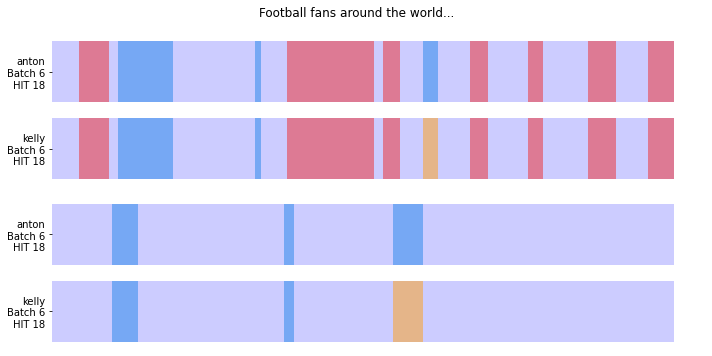

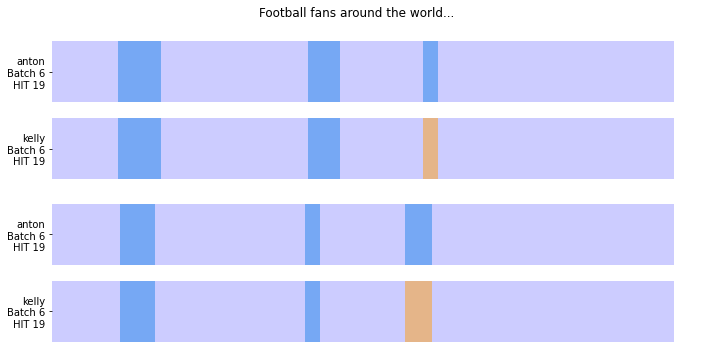

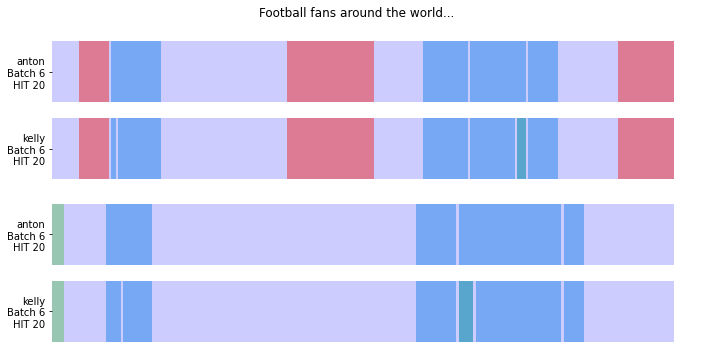

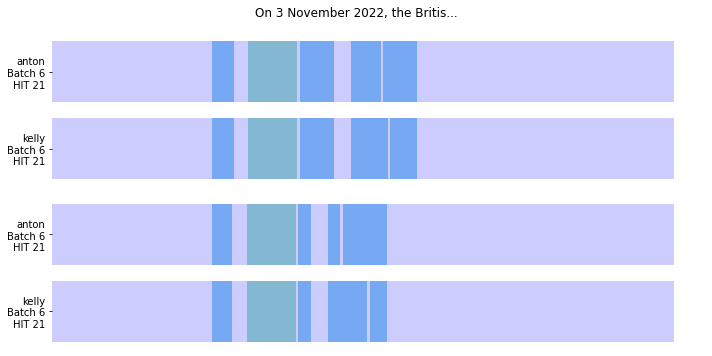

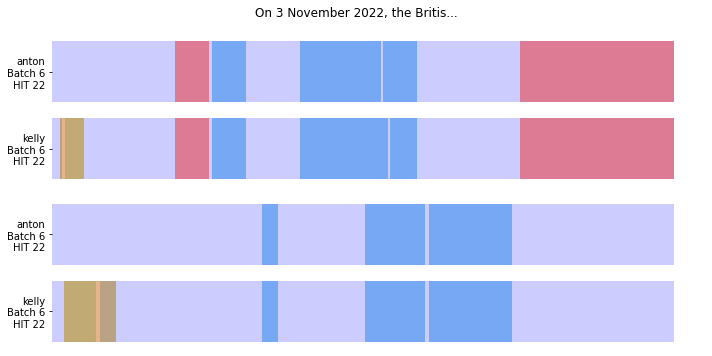

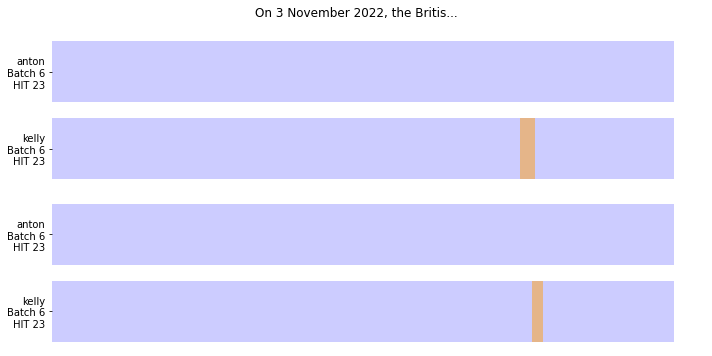

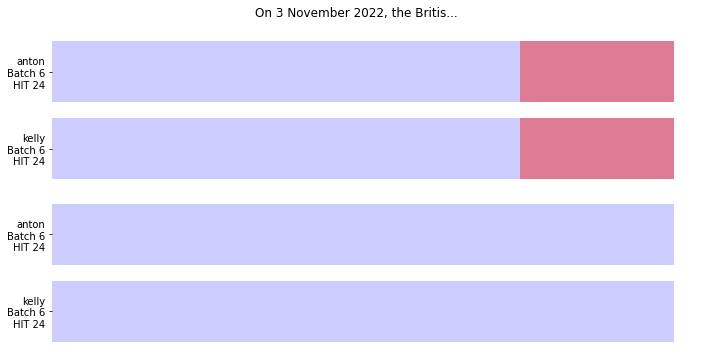

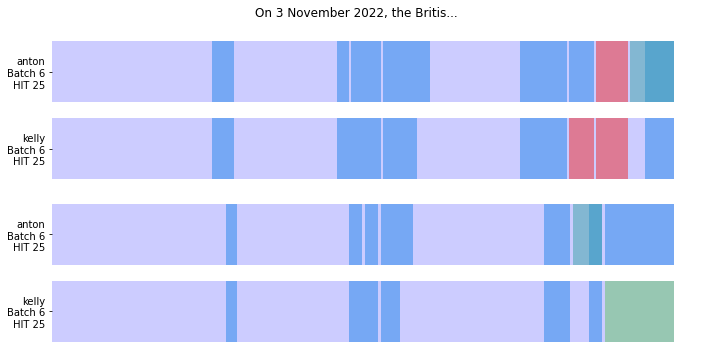

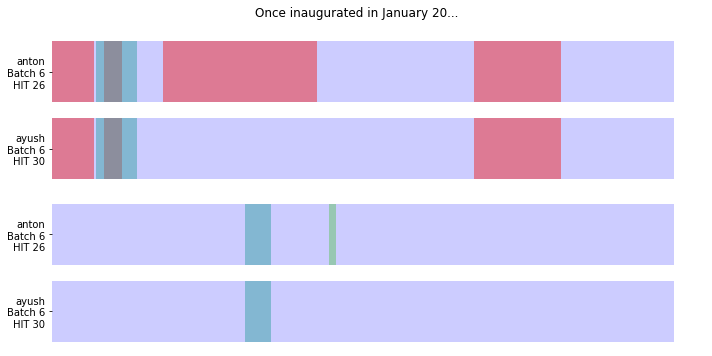

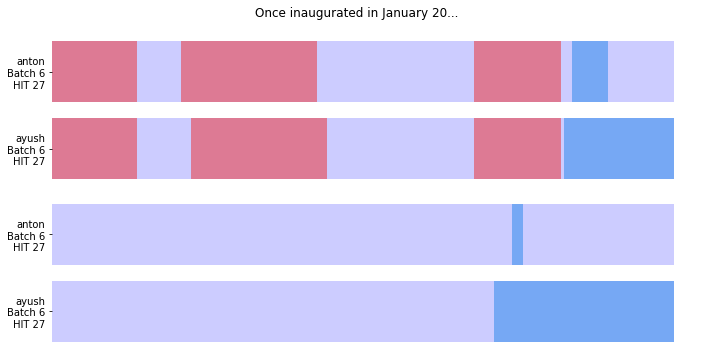

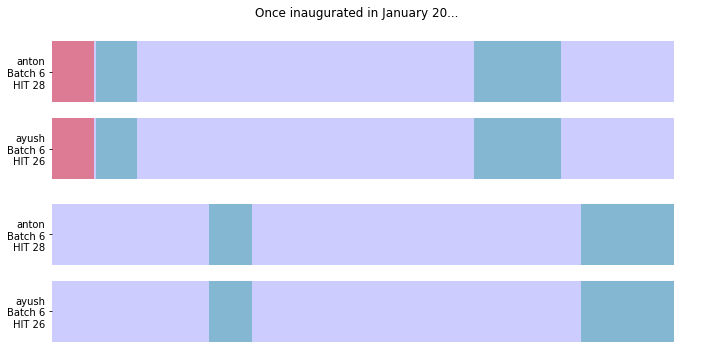

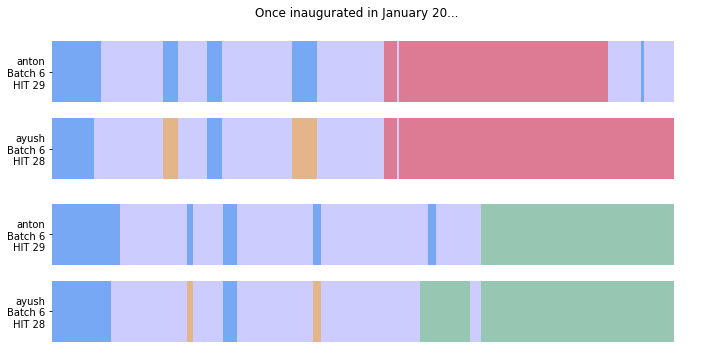

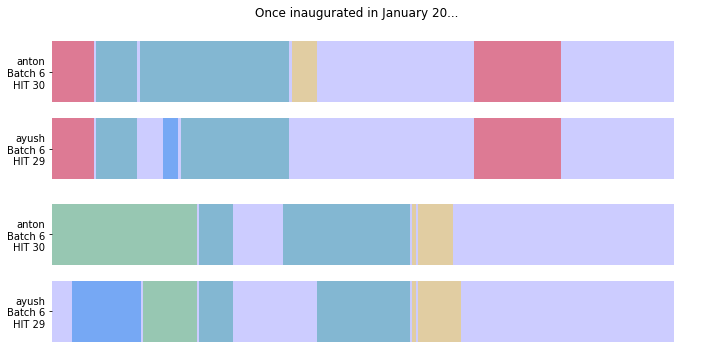

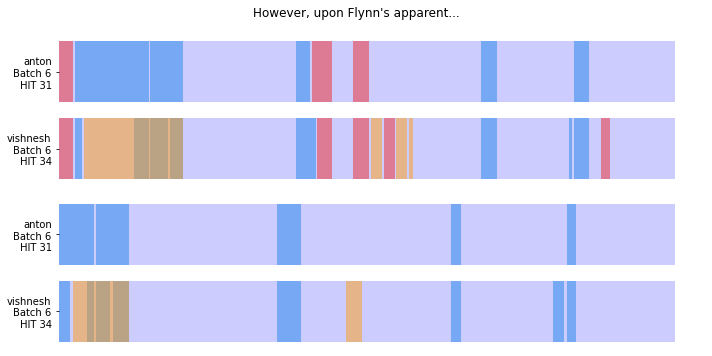

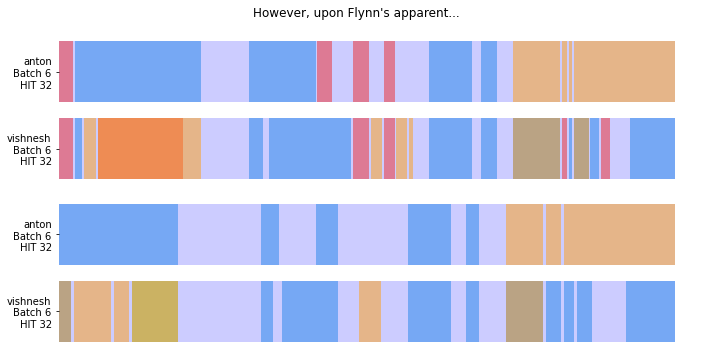

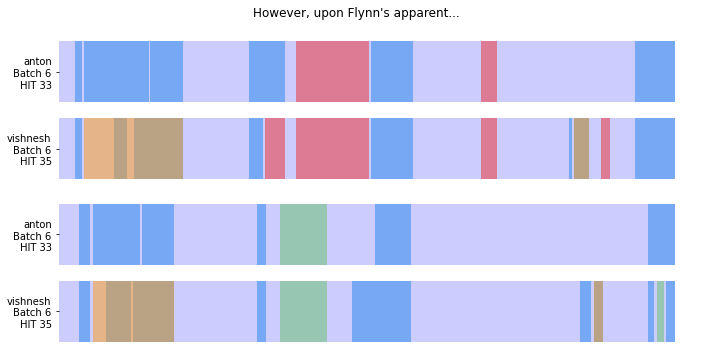

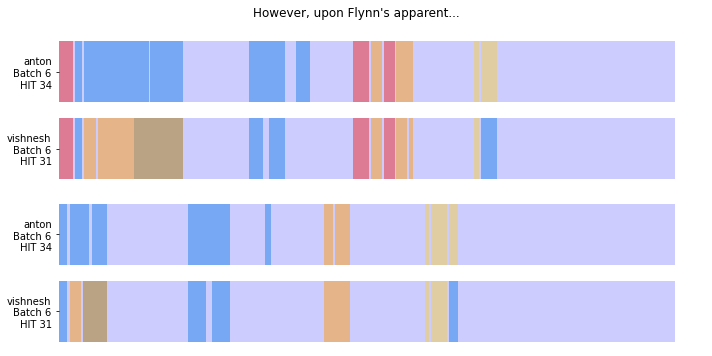

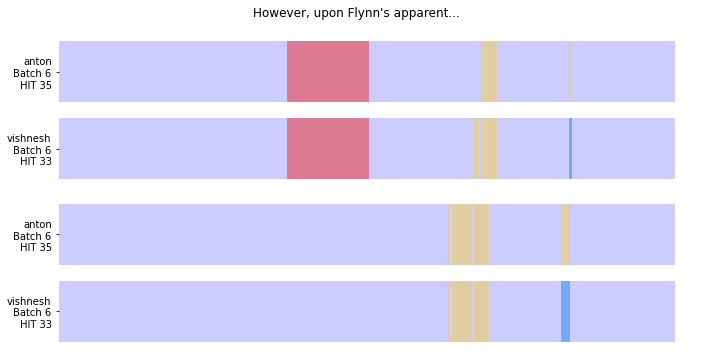

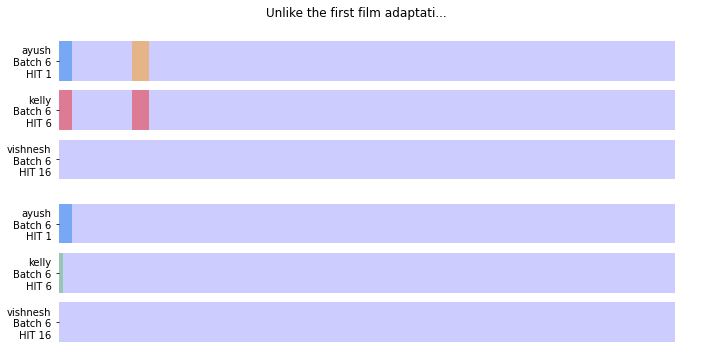

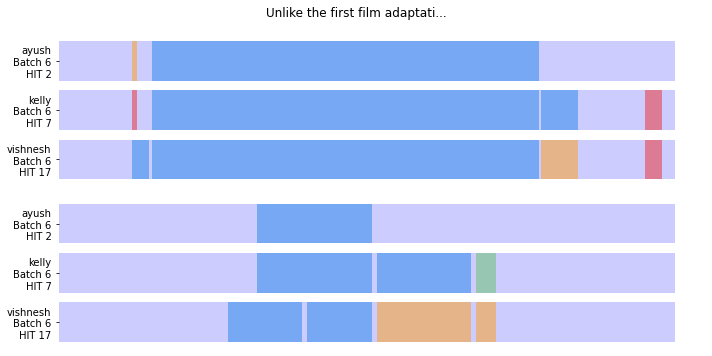

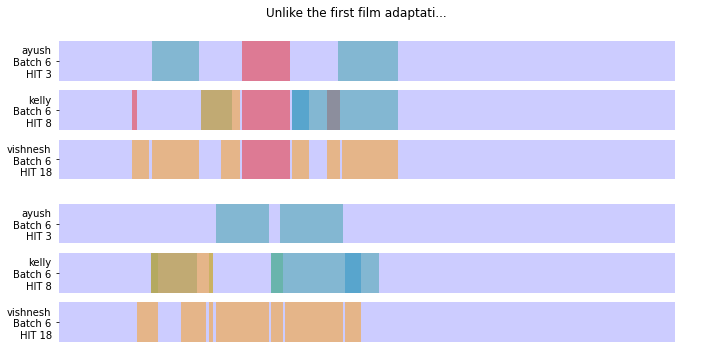

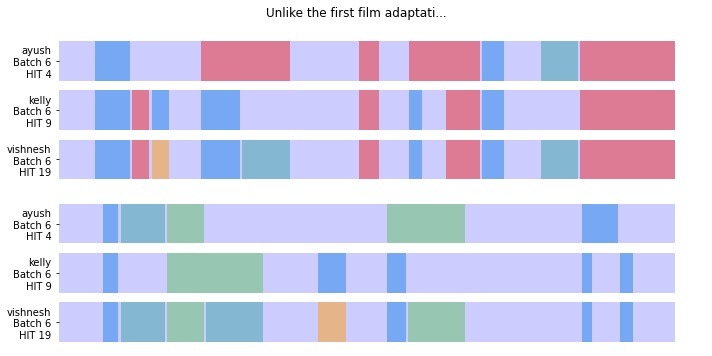

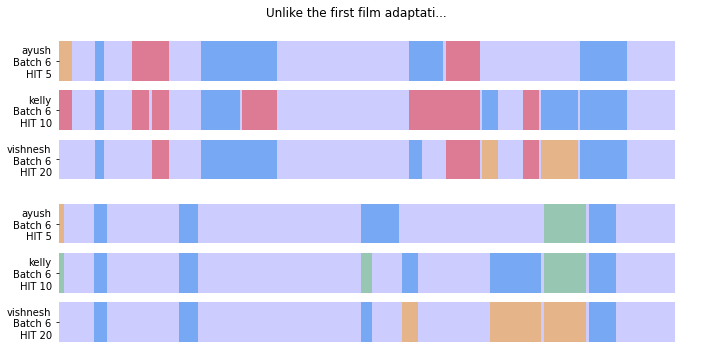

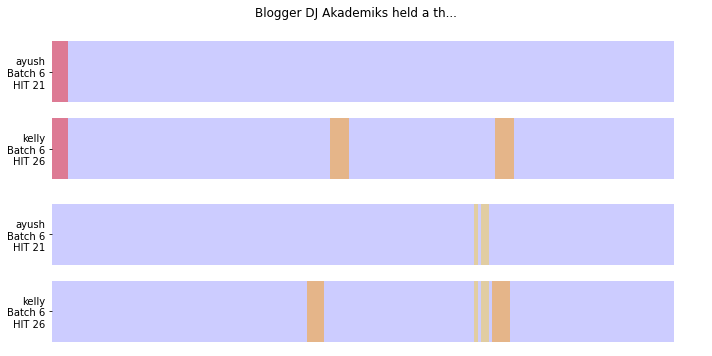

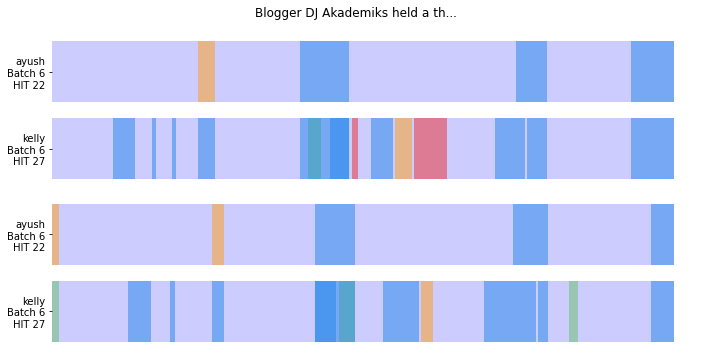

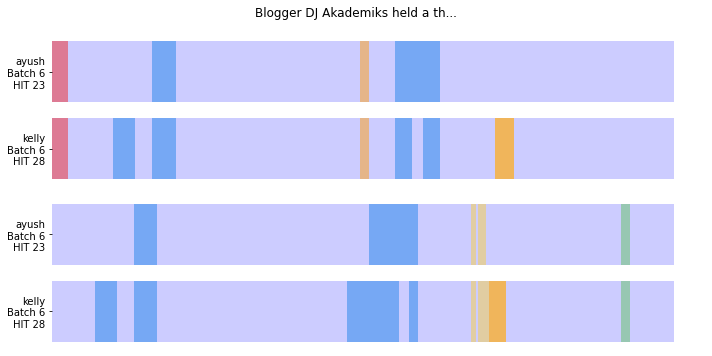

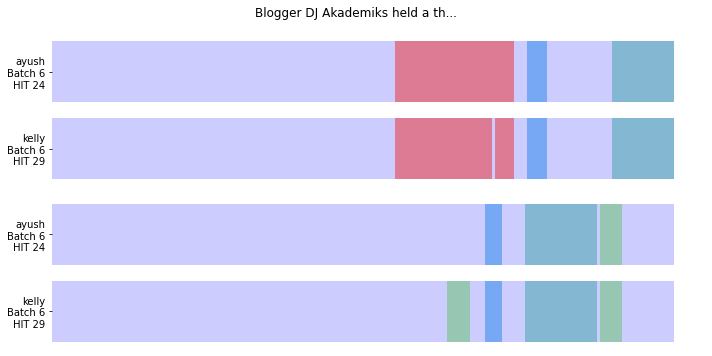

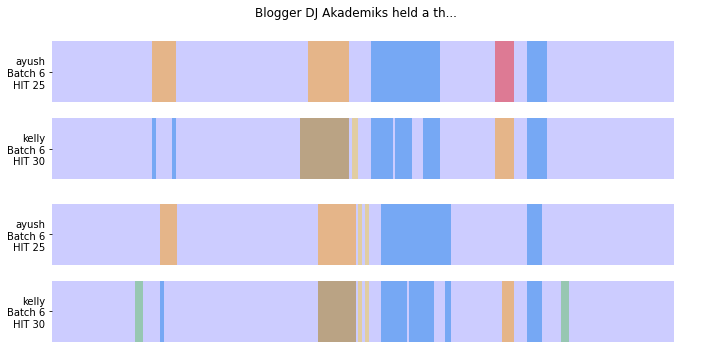

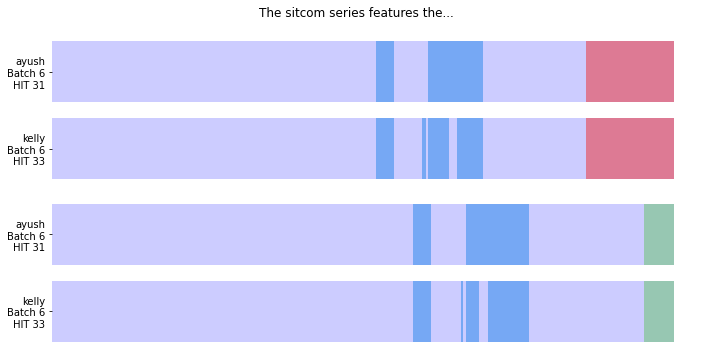

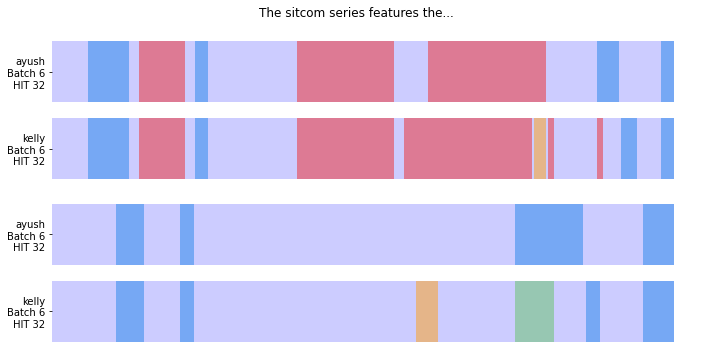

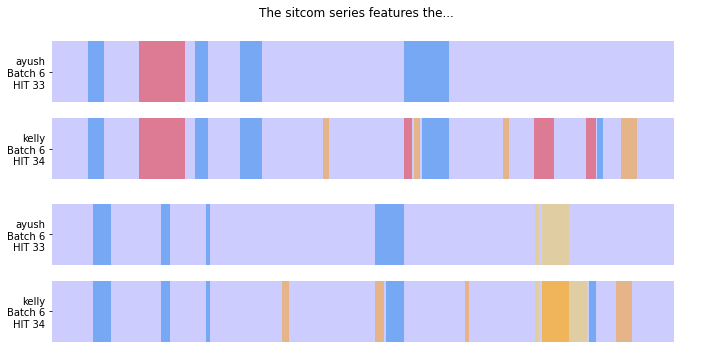

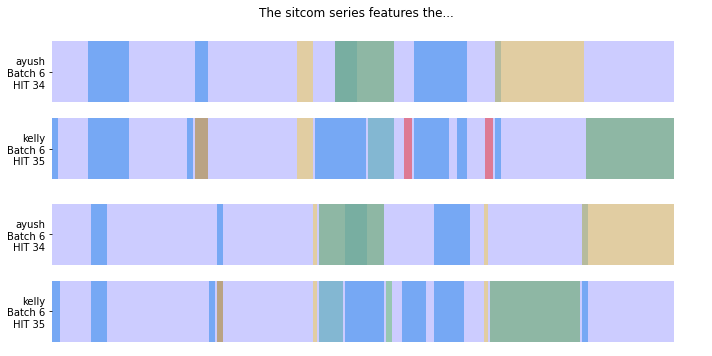

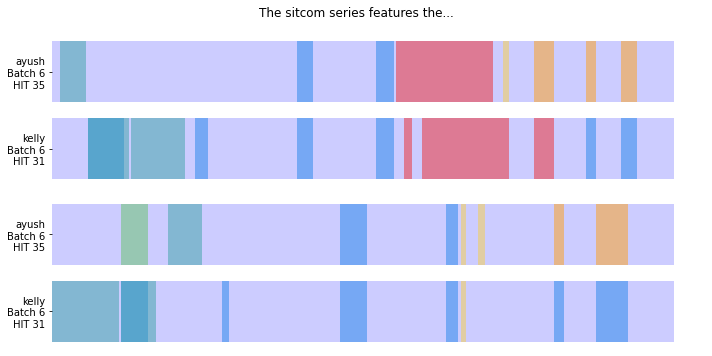

In [8]:
# Display the agreeement on all sentences
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    draw_agreement(sents)